<a href="https://colab.research.google.com/github/PanYuJ/steel-defect-detector_segmentation/blob/main/steel_defect_detecter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras import backend as K
import seaborn as sns
import cv2
import sklearn
import os
import zipfile
import shutil
import albumentations as A
import random

# 1.Loading data

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Jun  1 02:24:49 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
devices = tf.config.list_physical_devices('GPU')
print(devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
gpu_name = "GPU:0"

# define the strategy and pass in the device name
one_strategy = tf.distribute.OneDeviceStrategy(device=gpu_name)

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kypan123","key":"2198b0fec9ec5ec5a144f33b80b3ed13"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

ref                                                                   title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
arnabchaki/data-science-salaries-2023                                 Data Science Salaries 2023 💸                         25KB  2023-04-13 09:55:16          23922        671  1.0              
mauryansshivam/netflix-ott-revenue-and-subscribers-csv-file           Netflix OTT Revenue and Subscribers (CSV File)        2KB  2023-05-13 17:40:23           1457         34  1.0              
darshanprabhu09/stock-prices-for                                      Stock prices of Amazon , Microsoft , Google, Apple   85KB  2023-05-16 15:17:16           1323         34  1.0              
fatihb/coffee-quality-data-cqi

In [ ]:
!kaggle competitions download -c severstal-steel-defect-detection

 99% 1.56G/1.57G [00:15<00:00, 168MB/s]
100% 1.57G/1.57G [00:15<00:00, 111MB/s]


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
file_path = '/content/kaggle'
if not os.path.isdir(file_path):
  os.makedirs(file_path)

zip_path = '/content/severstal-steel-defect-detection.zip'
zf = zipfile.ZipFile(zip_path, 'r')
zf.extractall(file_path)


# 2.Data preprocessing


In [ ]:
def rle2mask(rle, width=1600, height=256, pixel_half=False):

    # CONVERT RLE TO MASK 
    if (pd.isnull(rle))|(rle==''):
      if pixel_half:
        return np.zeros((int(height/2),int(width/2)) ,dtype=np.uint8)
      else:
        return np.zeros((height,width) ,dtype=np.uint8)
    
    height= height
    width = width
    mask= np.zeros( width*height ,dtype=np.uint8)

    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]-1
    lengths = array[1::2]    
    for index, start in enumerate(starts):
      mask[int(start):int(start+lengths[index])] = 1

    if pixel_half:
      return mask.reshape( (height,width), order='F' )[::2,::2]

    else:
      return mask.reshape( (height,width), order='F' )[::1,::1]


def mask2rle(mask):
    startEnd = np.diff(np.concatenate(([0],mask.T.flatten(),[0])))
    starts   = np.where(startEnd== 1)[0]
    if len(starts) == 0:
        return ''
    ends     = np.where(startEnd==-1)[0]
    length   = ends - starts
    starts  += 1    # it seems the data set pixel index starts at 1
    return ' '.join(['{} {}'.format(s,l) for s,l in zip(starts,length)])


## 2.1. Create dataframe

In [ ]:
import sklearn

train = pd.read_csv("/content/gdrive/MyDrive/project/kaggle/Severstal_Steel Defect Detection_/train_main.csv")

# df['ClassId'] = df['ClassId'].astype(int)
# df.sort_values(by=['ImageId'])
# df_tmp = df.pivot(index='ImageId', columns='ClassId', values='EncodedPixels')
train['Image_name'] = train['ImageId_ClassId'].map(lambda x: x.split('.')[0]+'.jpg')
train2 = pd.DataFrame({'Image_name':train['Image_name'][::4]})

train2['e1'] = train['EncodedPixels'][::4].values
train2['e2'] = train['EncodedPixels'][1::4].values
train2['e3'] = train['EncodedPixels'][2::4].values
train2['e4'] = train['EncodedPixels'][3::4].values
train2.reset_index(inplace=True,drop=True)
train2.fillna('',inplace=True); 
train2['count'] = np.sum(train2.iloc[:,1:]!='',axis=1).values
train2['filepaths'] = ''
files_path = '/content/kaggle/train_images'
train2['filepaths'] = train2['Image_name'].apply(lambda x: os.path.join(files_path,x))
print('Count non_defect data:',len(train2[train2['count']==0]))
print('Count defect data:',len(train2[train2['count']!=0]))

train2_drop = train2.drop(train2[train2['count']==0].index)
# partial_non = train2[train2['count']==0].sample(int(len(train2[train2['count']!=0])*0.5), random_state=123)
# train_df2 = pd.concat([train2_drop, partial_non], ignore_index=True)
# print(f'Add {len(partial_non)} non_defect data')
# train_df2_shuffle = sklearn.utils.shuffle(train_df2, random_state=2000)
train_df2_shuffle = sklearn.utils.shuffle(train2_drop, random_state=2000)
train_df2_shuffle.reset_index(inplace=True,drop=True)
train_df2_shuffle

Count non_defect data: 5902
Count defect data: 6666


Image_name                                                 e1  \
0     068c6c4a9.jpg                                                      
1     d7e3d3784.jpg                                                      
2     670dc6f72.jpg                                                      
3     a37447f04.jpg                                                      
4     910127691.jpg                                                      
...             ...                                                ...   
6661  3da46ef9a.jpg                                                      
6662  9c4c38dab.jpg                                                      
6663  cbc2f9676.jpg                                                      
6664  bc9e35c07.jpg                                                      
6665  73d381ad2.jpg  367804 12 367837 11 368059 47 368315 49 368570...   

                                                     e2  \
0     379683 147 379939 147 380194 148 380450 148 38...   
1                                                         
2                                                         
3                                                         
4                                                         
...                                                 ...   
6661                                                      
6662                                                      
6663                                                      
6664                                                      
6665                                                      

                                                     e3  \
0                                                         
1     211353 19 211577 58 211801 98 212025 137 21224...   
2     137505 89 137745 156 137992 240 138247 242 138...   
3     21715 15 21955 41 22142 36 22195 63 22361 158 ...   
4     204291 16 204547 48 204803 80 205059 111 20531...   
...                                                 ...   
6661  75244 16 75469 47 75694 78 75919 109 76143 142...   
6662  177666 3 177922 8 178178 11 178434 11 178690 1...   
6663  265729 19 265985 55 266241 92 266497 128 26675...   
6664  67818 2 68072 5 68326 7 68559 5 68579 11 68813...   
6665                                                      

                                                     e4  count  \
0                                                            1   
1                                                            1   
2     193 19 440 68 688 77 939 82 1195 83 1451 84 17...      2   
3     334116 4 334369 11 334622 19 334875 27 335128 ...      2   
4                                                            1   
...                                                 ...    ...   
6661                                                         1   
6662                                                         1   
6663                                                         1   
6664                                                         1   
6665                                                         1   

                                       filepaths  
0     /content/kaggle/train_images/068c6c4a9.jpg  
1     /content/kaggle/train_images/d7e3d3784.jpg  
2     /content/kaggle/train_images/670dc6f72.jpg  
3     /content/kaggle/train_images/a37447f04.jpg  
4     /content/kaggle/train_images/910127691.jpg  
...                                          ...  
6661  /content/kaggle/train_images/3da46ef9a.jpg  
6662  /content/kaggle/train_images/9c4c38dab.jpg  
6663  /content/kaggle/train_images/cbc2f9676.jpg  
6664  /content/kaggle/train_images/bc9e35c07.jpg  
6665  /content/kaggle/train_images/73d381ad2.jpg  

[6666 rows x 7 columns]

In [ ]:
from sklearn.model_selection import train_test_split

def split_df(df, trsize):
  train_df, valid_df = train_test_split(df, train_size=trsize, shuffle=True, random_state=123)
  
  print('train_df length: ', len(train_df), 'valid_df length: ', len(valid_df)) 
  return train_df, valid_df    

train_df, valid_df = split_df(train_df2_shuffle, 0.9)
train_df.reset_index(inplace=True,drop=True)
valid_df.reset_index(inplace=True,drop=True)

num_non_train = len(train_df[train_df['count']==0])
num_non_valid = len(valid_df[valid_df['count']==0])

print(f'non_defect {num_non_train} in train_df')
print(f'non_defect {num_non_valid} in valid_df')

train_df length:  5999 valid_df length:  667
non_defect 0 in train_df
non_defect 0 in valid_df


In [ ]:
train_df

Image_name e1                                                 e2  \
0     38760254d.jpg                                                         
1     1c6625114.jpg                                                         
2     961333d4e.jpg                                                         
3     026183d85.jpg     120132 16 120388 46 120643 78 120899 108 12115...   
4     3159ee27a.jpg                                                         
...             ... ..                                                ...   
5994  de7e172fb.jpg                                                         
5995  0b4a68676.jpg                                                         
5996  b799d56cd.jpg                                                         
5997  e11ed6a65.jpg                                                         
5998  6085fc4cc.jpg                                                         

                                                     e3 e4  count  \
0     257217 64 257345 22454 279809 228 280065 210 2...         1   
1     118208 64 118337 191 118529 255 118785 255 119...         1   
2     165807 2 166063 6 166318 11 166574 14 166829 1...         1   
3                                                               1   
4     66 3 318 7 570 12 822 16 1075 19 1331 20 1587 ...         1   
...                                                 ... ..    ...   
5994  151809 128 152065 4032 156161 64 285654 43 285...         1   
5995  321550 2 321805 6 322061 9 322316 13 322572 16...         1   
5996  161933 8 162189 8 162444 9 162699 10 162954 11...         1   
5997  21498 7 21740 21 21982 35 22225 48 22467 62 22...         1   
5998  225035 62 225291 184 225547 245 225803 245 226...         1   

                                       filepaths  
0     /content/kaggle/train_images/38760254d.jpg  
1     /content/kaggle/train_images/1c6625114.jpg  
2     /content/kaggle/train_images/961333d4e.jpg  
3     /content/kaggle/train_images/026183d85.jpg  
4     /content/kaggle/train_images/3159ee27a.jpg  
...                                          ...  
5994  /content/kaggle/train_images/de7e172fb.jpg  
5995  /content/kaggle/train_images/0b4a68676.jpg  
5996  /content/kaggle/train_images/b799d56cd.jpg  
5997  /content/kaggle/train_images/e11ed6a65.jpg  
5998  /content/kaggle/train_images/6085fc4cc.jpg  

[5999 rows x 7 columns]

In [ ]:
valid_df

In [ ]:
def get_label(df):
  labels = []
  _df = df.copy()
  for i in range(len(_df)):
    label = []
    for j in range(4):
      if _df.iloc[i][j+1]!='':
        label.append('e'+str(j+1))
    if len(label)==0:
      label.append('e0')
    labels.append(label)    
  _df['labels'] = labels
  _df.reset_index(inplace=True,drop=True)
  return _df

# train_df_balance_full_final = get_label(train_df_balance_full)
# valid_df_final = get_label(valid_df)
# train_df_balance_full_final

train_df_final = get_label(train_df)
valid_df_final = get_label(valid_df)

In [ ]:
train_df_final.head(10)

Image_name e1 e2                                                 e3  \
0  65bb052e9.jpg        84 54 340 108 595 108 851 108 1107 107 1362 10...   
1  157f361ec.jpg        269526 43 269697 128 269869 212 270082 255 270...   
2  6a503e352.jpg                                                            
3  a2e96800f.jpg                                                            
4  d95a9bc58.jpg                                                            
5  d97933f5f.jpg        279703 12 279936 35 280169 58 280402 81 280635...   
6  847a45986.jpg                                                            
7  75e1f59ab.jpg                                                            
8  c5e2b8fff.jpg        297985 2 298241 6 298497 9 298753 13 299009 16...   
9  fd2f7b4f4.jpg                                                            

                                                  e4  count  \
0                                                         1   
1                                                         1   
2                                                         0   
3  218870 1 219124 4 219378 7 219632 10 219887 12...      1   
4                                                         0   
5                                                         1   
6                                                         0   
7                                                         0   
8                                                         1   
9                                                         0   

                                    filepaths labels  
0  /content/kaggle/train_images/65bb052e9.jpg   [e3]  
1  /content/kaggle/train_images/157f361ec.jpg   [e3]  
2  /content/kaggle/train_images/6a503e352.jpg   [e0]  
3  /content/kaggle/train_images/a2e96800f.jpg   [e4]  
4  /content/kaggle/train_images/d95a9bc58.jpg   [e0]  
5  /content/kaggle/train_images/d97933f5f.jpg   [e3]  
6  /content/kaggle/train_images/847a45986.jpg   [e0]  
7  /content/kaggle/train_images/75e1f59ab.jpg   [e0]  
8  /content/kaggle/train_images/c5e2b8fff.jpg   [e3]  
9  /content/kaggle/train_images/fd2f7b4f4.jpg   [e0]

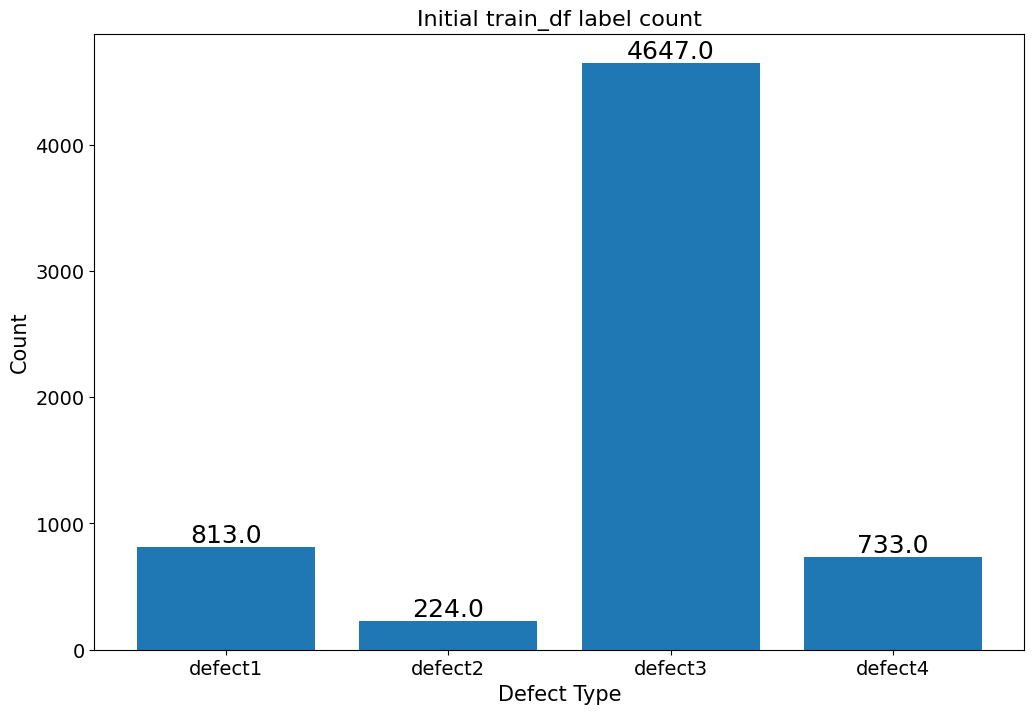

In [ ]:
plt.figure(figsize=(12,8))

defect_count = []
for i in range(1,5):
  defect_count.append(np.sum(train_df_final.iloc[:,i]!=''))

bar = plt.bar(['defect1', 'defect2', 'defect3', 'defect4'],defect_count)
plt.title('Initial train_df label count', fontsize=16)
plt.ylabel('Count', fontsize=15); plt.xlabel('Defect Type', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

for rect in bar:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.1f' % height,
             ha='center', va='bottom',fontsize=18)
plt.show()

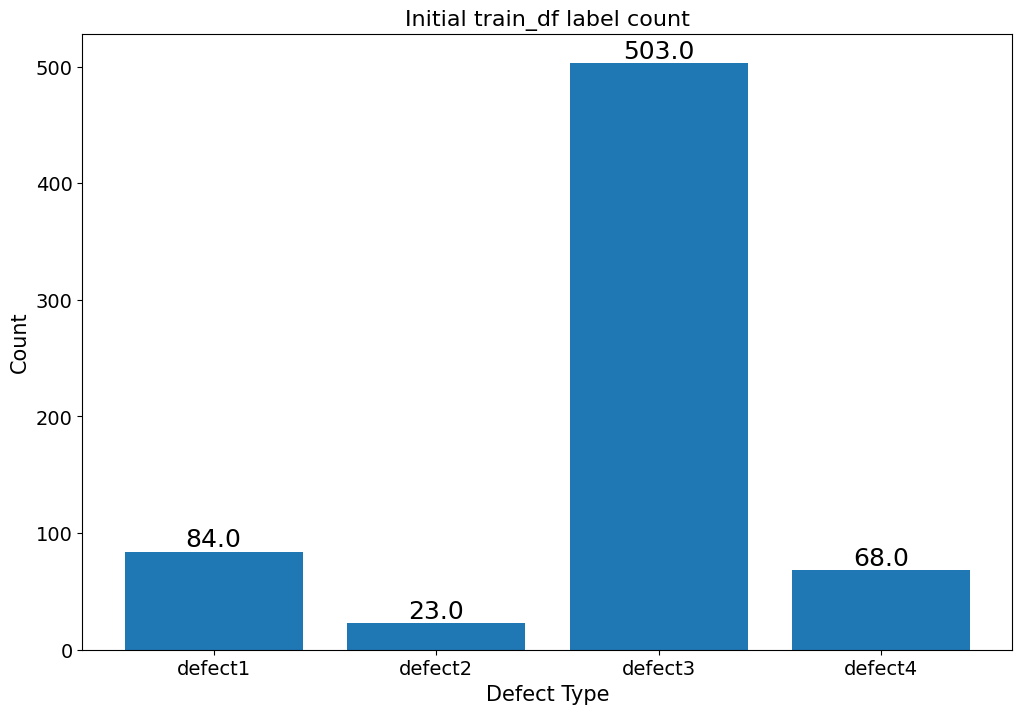

In [ ]:
plt.figure(figsize=(12,8))

defect_count = []
for i in range(1,5):
  defect_count.append(np.sum(valid_df_final.iloc[:,i]!=''))

bar = plt.bar(['defect1', 'defect2', 'defect3', 'defect4'],defect_count)
plt.title('Initial train_df label count', fontsize=16)
plt.ylabel('Count', fontsize=15); plt.xlabel('Defect Type', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

for rect in bar:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.1f' % height,
             ha='center', va='bottom',fontsize=18)
plt.show()

## 2.2. Cropping image function

In [ ]:
def add_mask_areas(train_df):
    '''
    Helper function to add mask area as a new column to the dataframe
    INPUT:
        train_df - dataset with training labels
    '''
    masks_df = train_df.copy()
    for i in range(4):
      masks_df['Area_'+str(i+1)] = 0

      
    for j, row in masks_df.iterrows():
      img = cv2.imread(masks_df['filepaths'].loc[j])
      for k in range(4):
        masks_df['Area_'+str(k+1)].loc[j] = np.sum(rle2mask(row['e'+str(k+1)], width=img.shape[1], height=img.shape[0]))
    
    return masks_df

In [ ]:
def crop_image(df, save_path, subset='train', crop_w_ratio=0.5, crop_h_ratio=1.0):

  """
  Arg:
    df: Dataframe contain image ID and mask rle
    save_path: The root of directory for saving cropped image and mask
    crop_w_ratio: The width ratio of slice image and mask
    crop_h_ratio: The height ratio of slice image and mask
  """
  
  # Check whether directory is exist in "save_path", or it create directory.
  if subset=='train':
    img_save_path = os.path.join(save_path, 'train_crop_images')
    
  if subset=='val':
    img_save_path = os.path.join(save_path, 'val_crop_images')

  if os.path.isdir(img_save_path):# start with an empty directory
    shutil.rmtree(img_save_path)
    
  if not os.path.isdir(img_save_path):
    os.makedirs(img_save_path)

  crop_df = pd.DataFrame(columns=['Image_name', 'Image_name_crop', 'e1', 'e2', 'e3', 'e4', 'filepaths'])
  img_crop_list = []
  rle_crop_list = []
  
  for idx in tqdm(range(len(df))):
    # Load image from Dataframe
    img_root = df['filepaths'].iloc[idx]
    img = cv2.imread(img_root, cv2.IMREAD_GRAYSCALE)
    
    # Load mask from Dataframe
    mask = np.zeros(shape=(256,1600,4))
    for i in range(4):
      mask[:, :, i] = rle2mask(df['e'+str(i+1)].iloc[idx])
      
    # Define size of image and mask after cropping
    crop_w = img.shape[1]*crop_w_ratio
    crop_h = img.shape[0]*crop_h_ratio

    # # Image and mask be cropped left and right side to 256*1536 
    # img = img[:,32:img.shape[1]-32]  
    # mask = mask[:,32:mask.shape[1]-32,:]

    # Cropping and saving
    for w in range(int(img.shape[1]/crop_w)):
      for h in range(int(img.shape[0]/crop_h)):

        # Cropping image
        img_crop = img[int(h*crop_h):int((h+1)*crop_h),int(w*crop_w):int((w+1)*crop_w)]

        # Define image name
        image_name_origin = os.path.splitext(img_root)[0]
        image_name_origin = image_name_origin.split('/')[-1]
        image_name_crop = image_name_origin+'_{}-{}.png'.format(w,h)

        save_root_img = os.path.join(img_save_path, image_name_crop)
        cv2.imwrite(img=img_crop, filename=save_root_img)

        # Cropping mask
        mask_crop = mask[int(h*crop_h):int((h+1)*crop_h), int(w*crop_w):int((w+1)*crop_w), :]
        rles = ['']*4
        for i in range(4):
          if mask_crop[:,:,i].sum()!=0:
            rle = mask2rle(mask_crop[:,:,i])
            rles[i] = rle
        stack_df = pd.DataFrame([[image_name_origin, image_name_crop, *rles, save_root_img]] ,columns=['Image_name', 'Image_name_crop', 'e1', 'e2', 'e3', 'e4', 'filepaths'])
        crop_df = pd.concat([crop_df, stack_df], axis=0, ignore_index=True)

  return crop_df 

In [ ]:
crop_df_train = crop_image(train_df, subset='train', save_path='/content/kaggle', crop_w_ratio=0.5, crop_h_ratio=1.0)
crop_df_val = crop_image(valid_df, subset='val', save_path='/content/kaggle', crop_w_ratio=0.5, crop_h_ratio=1.0)

100%|██████████| 1334/1334 [00:31<00:00, 41.98it/s]


In [ ]:
crop_df_train.fillna('',inplace=True)
crop_df_val.fillna('',inplace=True)

In [ ]:
crop_df_train.head(10)

Image_name    Image_name_crop  \
0  b2488a745  b2488a745_0-0.png   
1  b2488a745  b2488a745_1-0.png   
2  15ece0447  15ece0447_0-0.png   
3  15ece0447  15ece0447_1-0.png   
4  d407563d4  d407563d4_0-0.png   
5  d407563d4  d407563d4_1-0.png   
6  5b537b5fa  5b537b5fa_0-0.png   
7  5b537b5fa  5b537b5fa_1-0.png   
8  d5a1067a2  d5a1067a2_0-0.png   
9  d5a1067a2  d5a1067a2_1-0.png   

                                                  e1 e2  \
0                                                         
1                                                         
2                                                         
3                                                         
4                                                         
5                                                         
6                                                         
7                                                         
8                                                         
9  126504 4 126759 10 127000 7 127014 13 127255 3...      

                                                  e3  \
0                                                      
1                                                      
2                                                      
3  24321 13 24577 39 24833 65 25089 90 25345 116 ...   
4  14055 26 14261 76 14466 127 14672 177 14878 22...   
5  6072 4 6321 12 6572 18 6825 21 7079 24 7332 28...   
6                                                      
7                                                      
8                                                      
9                                                      

                                                  e4  \
0  119880 4 120136 10 120392 16 120648 34 120904 ...   
1  157700 1 157956 3 158212 5 158468 7 158724 9 1...   
2                                                      
3                                                      
4                                                      
5                                                      
6  161628 7 161882 13 161900 6 162136 48 162189 5...   
7                                                      
8                                                      
9                                                      

                                           filepaths  
0  /content/kaggle/train_crop_images/b2488a745_0-...  
1  /content/kaggle/train_crop_images/b2488a745_1-...  
2  /content/kaggle/train_crop_images/15ece0447_0-...  
3  /content/kaggle/train_crop_images/15ece0447_1-...  
4  /content/kaggle/train_crop_images/d407563d4_0-...  
5  /content/kaggle/train_crop_images/d407563d4_1-...  
6  /content/kaggle/train_crop_images/5b537b5fa_0-...  
7  /content/kaggle/train_crop_images/5b537b5fa_1-...  
8  /content/kaggle/train_crop_images/d5a1067a2_0-...  
9  /content/kaggle/train_crop_images/d5a1067a2_1-...

In [ ]:
def get_final_df (df):
  df = add_mask_areas(df)
  df_final = df.copy()

  for i in range(4):
    df_final['e'+str(i+1)].loc[df_final['Area_'+str(i+1)]<100]=''

  df_final['count'] = np.sum(df_final.iloc[:,2:6]!='',axis=1).values
  df_final.reset_index(inplace=True,drop=True)

  df_final = df_final.drop(df_final[df_final['count']==0].index)
  df_final = sklearn.utils.shuffle(df_final, random_state=2000)
  df_final.reset_index(inplace=True,drop=True)

  return df_final

In [ ]:
crop_df_train_final = get_final_df(crop_df_train)
crop_df_val_final = get_final_df(crop_df_val)

In [ ]:
crop_df_train_final.head(10)

In [ ]:
plt.figure(figsize=(15,8))
df_ = crop_df_train_final[crop_df_train_final['e4']!='']
df_ = df_[df_['Area_4']>100].sample(16)
for idx in range(16):
  
  plt.subplot(4,4,idx+1)
  extra = '  has defect'
  # img_path = crop_df_train['filepaths'].iloc[idx]
  img_path = df_['filepaths'].iloc[idx]
  img = cv2.imread(img_path, cv2.IMREAD_COLOR)
  img = img.astype(np.float32)/ 255.0
  # img = cv2.resize(img, interpolation=cv2.INTER_LINEAR)

  # mask = np.zeros(shape=(256,1600,5))
  mask = np.zeros(shape=(256,800,1))
  # for i in range(4):    
  #   # rle_msk = rle2mask(crop_df_train['e'+str(i+1)].iloc[idx], width=400, height=256)
  #   rle_msk = rle2mask(train_df['e'+str(i+1)].iloc[idx])
  #   rle_msk = rle_msk.astype(np.float32)
  #   mask[:,:,i+1] = rle_msk
  # mask[:,:,0] = 1-mask[:,:,1:5].sum(-1)
  # mask = cv2.resize(mask, (1600,256), interpolation=cv2.INTER_LINEAR)
  for i in range(4):
    rle_msk = rle2mask(df_['e'+str(i+1)].iloc[idx], width=800, height=256)
    # rle_msk = cv2.resize(rle_msk,interpolation=cv2.INTER_NEAREST)     
    mask[rle_msk==1,0] = i+1

  for k in range(5):

    # if k==0:
    #   # yellow
    #   img[mask[:,:,k+1]==1,0] = 235 
    #   img[mask[:,:,k+1]==1,1] = 235
    # if k==1:
    #   # green
    #   img[mask[:,:,k+1]==1,1] = 210
    # if k==2:
    #   # blue
    #   img[mask[:,:,k+1]==1,2] = 255
    # if k==3:
    #   # magenta          
    #   img[mask[:,:,k+1]==1,0] = 255
    #   img[mask[:,:,k+1]==1,2] = 255
    if k==1:
      # yellow
      img[mask[:,:,0]==k,0] = 235 
      img[mask[:,:,0]==k,1] = 235
    if k==2:
      # green
      img[mask[:,:,0]==k,1] = 210
    if k==3:
      # blue
      img[mask[:,:,0]==k,2] = 255
    if k==4:
      # magenta
      img[mask[:,:,0]==k,0] = 255
      img[mask[:,:,0]==k,2] = 255

  if extra=='  has defect ': 
    extra =''
  img_name = os.path.basename(img_path)
  plt.title('Train '+img_name)
  plt.axis('off') 
  plt.imshow(img)

## 2.3. Oversample

In [ ]:
def balance(df, column, working_dir):
    def get_augmented_image(image, mask):
      width = int(image.shape[1])
      height = int(image.shape[0])
      transform = A.Compose([
          A.HorizontalFlip(p=0.5),
          A.VerticalFlip(p=0.5),
          # A.RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.25),           
          A.RandomGamma(p=0.5),
          # A.RandomRotate90(p=0.5)
          ])
      transformed = transform(image=image, mask=mask)
      image, mask = transformed['image'], transformed['mask']
      return image, mask
        
    def dummy(image):
      return image

    df = df.copy()
    train_df_balance = pd.DataFrame(columns=['filepaths', 'e1', 'e2', 'e3', 'e4', 'Image_name'])
    print('Initial length of dataframe is ', len(df))
    aug_dir = os.path.join(working_dir, 'aug')# directory to store augmented images
    
    if os.path.isdir(aug_dir):# start with an empty directory
      shutil.rmtree(aug_dir)

    if not os.path.exists(aug_dir):
      os.mkdir(aug_dir)

    # create and store the augmented images  
    total = 0
    img_paths = []
    rles = []
    img_names = []

    nonan = np.sum(df.loc[:,column]!='', axis=0)
    n = nonan.max() # determine how many samples there are in this class
    max_column = str(nonan.idxmax())
    sample_count = nonan.values

    groups = df.groupby('count') # group by defect count
    count = groups.get_group(1) # one defect

    for idx, label in enumerate(column):  # for every class 
      if label != max_column:
        defect = count[count[label]!='']  # a dataframe holding only rows with the specified label
        target_count = len(defect)
         
        if sample_count[idx] < n: # if the class has less than target number of images
          aug_img_count = 0
          delta = n - sample_count[idx]  # number of augmented images to create
          target_dir = os.path.join(aug_dir, label)

          dir_path = os.path.join(aug_dir,label)

          if not os.path.exists(dir_path):
            os.mkdir(dir_path) # make class directories within aug directory
                      
          desc = f'augmenting class {label}'
          for i in tqdm(range(delta), ncols=120, unit='files', colour='blue',desc=desc):
            init_rle = ['']*len(column)
            j = i % target_count
            img_path = defect['filepaths'].iloc[j]
            img_name = defect['Image_name'].iloc[j]
            img = cv2.imread(img_path)

            mask = rle2mask(defect[label].iloc[j], height=img.shape[0], width=img.shape[1])
            img, mask = get_augmented_image(img, mask)

            mask_rle = mask2rle(mask)
            init_rle[idx] = mask_rle

            fname = os.path.basename(img_path)
            fname = fname.split('.')[0]
            fname = 'aug' +str(i) +'-' + fname + '.png'
            dest_path = os.path.join(target_dir, fname) # define where to write the images              
            cv2.imwrite(dest_path, img)
            stack_df = pd.DataFrame([[dest_path, *init_rle]], columns=['filepaths', 'e1', 'e2', 'e3', 'e4'])

            train_df_balance = pd.concat([train_df_balance, stack_df], axis=0, ignore_index=True)
            # img_paths.append(dest_path)
            # rles.append(init_rle)
            # img_names.append(img_name)

            aug_img_count +=1
          total +=aug_img_count
   
    print('Total Augmented images created= ', total)

    train_df = pd.concat([train_df_balance, df],axis=0, ignore_index=True)
    return train_df 


In [ ]:
# # Input crop image  
# target_columns = ['e1','e2','e3','e4']

# working_dir = '/content/kaggle'
# train_df_balance = balance(crop_df_train_final, target_columns, working_dir)
# train_df_balance = sklearn.utils.shuffle(train_df_balance, random_state=2000)
# train_df_balance.reset_index(inplace=True,drop=True)

Initial length of dataframe is  7583


augmenting class e4: 100%|███████████████████████████████████████████████████████| 5055/5055 [02:39<00:00, 31.71files/s]

Total Augmented images created=  15854


In [ ]:
# Input full size image
target_columns = ['e1','e2','e3','e4']
working_dir = '/content/kaggle'
train_df_balance_full = balance(train_df, target_columns, working_dir)
train_df_balance_full = sklearn.utils.shuffle(train_df_balance_full, random_state=2000)
train_df_balance_full.reset_index(inplace=True,drop=True)

Initial length of dataframe is  5332


augmenting class e4: 100%|███████████████████████████████████████████████████████| 3489/3489 [02:40<00:00, 21.70files/s]

Total Augmented images created=  10858


In [ ]:
train_df_final

In [ ]:
plt.figure(figsize=(12,8))

defect_count = []
for i in range(2,6):
  # defect_count.append(np.sum(crop_df_train.iloc[:,i]!=''))
  defect_count.append(np.sum(crop_df_train.iloc[:,i]!=''))
  
bar = plt.bar(['defect1', 'defect2', 'defect3', 'defect4'],defect_count)
plt.title('Initial train_df label count', fontsize=16)
plt.ylabel('Count', fontsize=15); plt.xlabel('Defect Type', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

for rect in bar:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.1f' % height,
             ha='center', va='bottom',fontsize=18)
plt.show()

In [ ]:
plt.figure(figsize=(12,8))

defect_count = []
for i in range(1,5):
  defect_count.append(np.sum(train_df_balance.iloc[:,i]!=''))

bar = plt.bar(['defect1', 'defect2', 'defect3', 'defect4'],defect_count)
plt.title('Initial train_df label count', fontsize=16)
plt.ylabel('Count', fontsize=15); plt.xlabel('Defect Type', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

for rect in bar:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.1f' % height,
             ha='center', va='bottom',fontsize=18)
plt.show()

In [ ]:
# Calculate class weights for dealing imbalanced dataset.
n_samples = np.sum(defect_count)
to_insert = len(crop_df_train)
defect_count_b = [to_insert, *defect_count]
n_classes = 5
class_weights = n_samples / [i * n_classes for i in defect_count_b]
print(class_weights)

[ 0.20471358  1.95733761 10.56623377  0.26398443  1.64918919]


In [ ]:
crop_df_train_final.head(10)

In [ ]:
import albumentations as A


root = '/content/kaggle/train_crop_images'
a = A.RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=1.0)
b = A.RandomGamma(p=1.0)
c = A.RandomRotate90(p=1.0)

# d = A.MedianBlur(blur_limit=3, p=1.0)
# f = A.Blur(blur_limit=3, p=1.0)


defects = list(crop_df_train_final[crop_df_train_final['e1']!=''].sample(4).index)
defects += list(crop_df_train_final[crop_df_train_final['e2']!=''].sample(4).index)
defects += list(crop_df_train_final[crop_df_train_final['e3']!=''].sample(4).index)
defects += list(crop_df_train_final[crop_df_train_final['e4']!=''].sample(4).index)



aug_list = [a,b,c]
for aug in aug_list:
  plt.figure(figsize=(15,8))
  for idx in range(16):
    
    plt.subplot(4,4,idx+1)
    extra = '  has defect'
    # img_path = crop_df_train['filepaths'].iloc[idx]
    img_path = crop_df_train_final[crop_df_train_final.index.isin(defects)]['filepaths'].iloc[idx]
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = img.astype(np.float32)/ 255.0
    # img = cv2.resize(img, interpolation=cv2.INTER_LINEAR)

    # mask = np.zeros(shape=(256,1600,5))
    mask = np.zeros(shape=(256,256,1))
    # for i in range(4):    
    #   # rle_msk = rle2mask(crop_df_train['e'+str(i+1)].iloc[idx], width=400, height=256)
    #   rle_msk = rle2mask(train_df['e'+str(i+1)].iloc[idx])
    #   rle_msk = rle_msk.astype(np.float32)
    #   mask[:,:,i+1] = rle_msk
    # mask[:,:,0] = 1-mask[:,:,1:5].sum(-1)
    # mask = cv2.resize(mask, (1600,256), interpolation=cv2.INTER_LINEAR)
    for i in range(4):
      rle_msk = rle2mask(crop_df_train_final[crop_df_train_final.index.isin(defects)]['e'+str(i+1)].iloc[idx], width=256, height=256)
     
      # rle_msk = cv2.resize(rle_msk,interpolation=cv2.INTER_NEAREST)     
      mask[rle_msk==1,0] = i+1
      
    transformed = aug(image=img, mask=mask)
    img = transformed['image']
    mask = transformed['mask']

    for k in range(5):

      # if k==0:
      #   # yellow
      #   img[mask[:,:,k+1]==1,0] = 235 
      #   img[mask[:,:,k+1]==1,1] = 235
      # if k==1:
      #   # green
      #   img[mask[:,:,k+1]==1,1] = 210
      # if k==2:
      #   # blue
      #   img[mask[:,:,k+1]==1,2] = 255
      # if k==3:
      #   # magenta          
      #   img[mask[:,:,k+1]==1,0] = 255
      #   img[mask[:,:,k+1]==1,2] = 255
      if k==1:
        # yellow
        img[mask[:,:,0]==k,0] = 235 
        img[mask[:,:,0]==k,1] = 235
      if k==2:
        # green
        img[mask[:,:,0]==k,1] = 210
      if k==3:
        # blue
        img[mask[:,:,0]==k,2] = 255
      if k==4:
        # magenta          
        img[mask[:,:,0]==k,0] = 255
        img[mask[:,:,0]==k,2] = 255

    if extra=='  has defect ': 
      extra =''
    img_name = os.path.basename(img_path)
    plt.title('Train '+img_name)
    plt.axis('off') 
    plt.imshow(img)
# plt.subplots_adjust(wspace=0.05)
# plt.show()


In [ ]:
train_df_balance.head(10)

filepaths  \
0  /content/kaggle/aug/e1/aug2848-d89d52e53.jpg   
1  /content/kaggle/aug/e2/aug3868-5238bc100.jpg   
2    /content/kaggle/train_images/40f56ca26.jpg   
3  /content/kaggle/aug/e4/aug1328-d169e1b81.jpg   
4    /content/kaggle/train_images/940e8cd2f.jpg   
5   /content/kaggle/aug/e2/aug521-b963c168c.jpg   
6    /content/kaggle/train_images/bf24a03ac.jpg   
7    /content/kaggle/train_images/9d3b4a019.jpg   
8  /content/kaggle/aug/e1/aug2927-fb352c185.jpg   
9   /content/kaggle/aug/e4/aug413-5b537b5fa.jpg   

                                                  e1  \
0  289526 5 289773 14 290021 22 290268 31 290515 ...   
1                                                      
2                                                      
3                                                      
4                                                      
5                                                      
6                                                      
7                                                      
8  379987 4 380028 5 380238 14 380282 13 380490 2...   
9                                                      

                                                  e2  \
0                                                      
1  39724 3 39945 39 40195 47 40451 48 40707 47 40...   
2                                                      
3                                                      
4                                                      
5  299532 10 299788 30 300044 50 300299 70 300555...   
6                                                      
7                                                      
8                                                      
9                                                      

                                                  e3  \
0                                                      
1                                                      
2                                                      
3                                                      
4  263043 8 263299 24 263555 40 263811 55 264067 ...   
5                                                      
6  376835 2 377091 6 377347 10 377603 14 377859 1...   
7                                                      
8                                                      
9                                                      

                                                  e4     Image_name  count  \
0                                                               NaN    NaN   
1                                                               NaN    NaN   
2  446 4 702 11 958 18 1214 22 1470 23 1726 24 19...  40f56ca26.jpg    1.0   
3  8461 122 8717 126 8973 130 9229 133 9485 137 9...            NaN    NaN   
4  125772 3 126027 8 126281 13 126536 15 126791 1...  940e8cd2f.jpg    2.0   
5                                                               NaN    NaN   
6                                                     bf24a03ac.jpg    1.0   
7  267258 2 267510 6 267762 10 268015 14 268267 1...  9d3b4a019.jpg    1.0   
8                                                               NaN    NaN   
9  161695 7 161936 6 161947 13 162160 5 162170 48...            NaN    NaN   

     labels  
0      [e1]  
1      [e2]  
2      [e4]  
3      [e4]  
4  [e3, e4]  
5      [e2]  
6      [e3]  
7      [e4]  
8      [e1]  
9      [e4]

## 2.4. Augmentations

In [ ]:
import albumentations as A
augmentations = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),

    ])

## 2.5. Data Generater

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(horizontal_flip=True,
                  vertical_flip=True,
                  rescale=1/255.0,

                  )

valid_gen = ImageDataGenerator(rescale=1/255.0,
                  )

train_data = train_gen.flow_from_dataframe(train_df_final,
                        directory='/content/kaggle/train_images',
                        x_col='Image_name',
                        y_col='labels',
                        target_size=(256, 1600),
                        color_mode='rgb',
                        class_mode='categorical',
                        classes=None,
                        batch_size=8,
                        shuffle=True,                   
                        )

valid_data = valid_gen.flow_from_dataframe(valid_df_final,
                        directory='/content/kaggle/train_images',            
                        x_col='Image_name',
                        y_col='labels',
                        target_size=(256, 1600),
                        color_mode='rgb',
                        class_mode='categorical',
                        classes=None,
                        batch_size=8,
                        shuffle=False,
                        )

In [ ]:
import imgaug as ia
import imgaug.augmenters as iaa
import cv2
from sklearn.utils import class_weight

path = '/content/kaggle/'
class DataGenerator2(tf.keras.utils.Sequence):
  def __init__(self, df, input_size = (256,1600), batch_size = 8, subset="train", data_path='/content/kaggle/train_images/',
               shuffle=False, pixel_half=False, info={}, 
               augment_transform=None, plot_mode=False, label_sparse=False, mask_label_mode='multi'):
    super().__init__()
    self.df = df
    self.shuffle = shuffle
    self.subset = subset
    self.batch_size = batch_size
    self.pixel_half = pixel_half
    self.mask_size = input_size

    if self.pixel_half:
      self.image_size = (int(input_size[0]/2), int(input_size[1]/2)) # (height, width)
    else:
      self.image_size = (input_size[0], input_size[1])


    self.info = info  
    self.augment_transform = augment_transform
    self.plot_mode = plot_mode
    self.label_sparse = label_sparse
    self.mask_label_mode = mask_label_mode
    self.on_epoch_end()
    self.data_path = data_path

  def __len__(self):
    return int(np.floor(len(self.df) / self.batch_size))
  
  def on_epoch_end(self):
    self.indexes = np.arange(len(self.df))
    if self.shuffle == True:
      np.random.shuffle(self.indexes)
  
  def __getitem__(self, index):
    
    if self.plot_mode:
      # store image and label in RGB 
      X = np.empty((self.batch_size,self.image_size[0],self.image_size[1],3),dtype=np.float32)
    else:
      # store image and label in grayscale mode
      X = np.empty((self.batch_size,self.image_size[0],self.image_size[1],1),dtype=np.float32)

    # Convert rle to mask
    if self.mask_label_mode =='multi':
      if self.label_sparse:
        y = np.zeros((self.batch_size,self.image_size[0],self.image_size[1],1),dtype=np.float32)
      else:
        y = np.zeros((self.batch_size,self.image_size[0],self.image_size[1],5),dtype=np.float32)

    if self.mask_label_mode =='binary':
        y = np.zeros((self.batch_size,self.image_size[0],self.image_size[1],4),dtype=np.float32)

    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

    for i, f in enumerate(self.df['filepaths'].iloc[indexes]):
      img_name = os.path.basename(f)
      self.info[index*self.batch_size+i]=img_name

      if self.plot_mode:
        # load image in RGB
        image = cv2.imread(f, cv2.IMREAD_COLOR)
        image = image.astype(np.float32) /255.
        image = cv2.resize(image,(self.image_size[1],self.image_size[0]),interpolation=cv2.INTER_LINEAR)
        X[i,] = image
        
      else:
        # load image in grayscale
        image = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
        image = image.astype(np.float32) /255.
        image = cv2.resize(image,(self.image_size[1],self.image_size[0]),interpolation=cv2.INTER_LINEAR)
        image = image[:,:,np.newaxis]
        X[i,] = image

      if self.subset == 'train' or self.subset == 'val':
        # Convert rle to mask
        if self.mask_label_mode =='multi':
          if self.label_sparse: 
            for j in range(4):
              rle_msk = rle2mask(self.df['e'+str(j+1)].iloc[indexes[i]], width=self.mask_size[1], height=self.mask_size[0], pixel_half=self.pixel_half)                
              rle_msk = rle_msk.astype(np.float32)
              # rle_msk = cv2.resize(rle_msk, (1600,256),interpolation=cv2.INTER_NEAREST)     
              y[i,rle_msk==1,0] = j+1

          else:
            for j in range(4):
              rle_msk = rle2mask(self.df['e'+str(j+1)].iloc[indexes[i]], width=self.mask_size[1], height=self.mask_size[0], pixel_half=self.pixel_half)
              rle_msk = rle_msk.astype(np.float32)
              y[i,:,:,j+1] = rle_msk
            y[i,:,:,0] = 1-y[i,:,:,1:5].sum(-1)

        if self.mask_label_mode =='binary':
          for j in range(4):
            rle_msk = rle2mask(self.df['e'+str(j+1)].iloc[indexes[i]], width=self.mask_size[1], height=self.mask_size[0], pixel_half=self.pixel_half)
            rle_msk = rle_msk.astype(np.float32)
            # rle_msk = cv2.resize(rle_msk, (1600,256),interpolation=cv2.INTER_NEAREST)
            y[i,:,:,j] = rle_msk
                    
        
        if self.subset == 'train': 
          
          # Agumentation
          if self.augment_transform != None:
            transformed = self.augment_transform(image=X[i,], mask=y[i,])
            X[i,] = transformed['image']
            y[i,] = transformed['mask'] 

    if self.subset == 'train' or self.subset == 'val':
      return X, y
  
    else: return X


In [ ]:
filenames={}

plot_img = DataGenerator_crop(crop_df_train_final, 
                              subset='train', batch_size=8, 
                              plot_mode=True, info=filenames, augment_transform=augmentations, label_sparse=False, mask_label_mode='multi')
print('Images and masks from our Data Generator')
print('KEY: yellow=defect1, green=defect2, blue=defect3, magenta=defect4')

# DISPLAY IMAGES WITH DEFECTS
for i,batch in enumerate(plot_img):
  plt.figure(figsize=(15, 15))
  for k in range(8):
    plt.subplot(4,4,k+1)
    img_origin = batch[0][k,]       
    img_origin_p = img_origin.copy()                   
    extra = '  has defect '
    msk_origin = batch[1][k,]
    if len(np.unique(msk_origin))>1:
      for m in range(4): 
        if np.sum(msk_origin[:,:,m])>0:
          extra += ' '+str(m+1)
        if m ==0:
          # yellow
          img_origin_p[msk_origin[:,:,m+1]==1,0] = 235 
          img_origin_p[msk_origin[:,:,m+1]==1,1] = 235

        if m ==1:
          # green
          img_origin_p[msk_origin[:,:,m+1]==1,1] = 210

        if m ==2: 
          # blue
          img_origin_p[msk_origin[:,:,m+1]==1,2] = 255

        if m ==3:
          # magenta          
          img_origin_p[msk_origin[:,:,m+1]==1,0] = 255
          img_origin_p[msk_origin[:,:,m+1]==1,2] = 255
      
    if extra=='  has defect ': extra =''
    plt.title('Train '+filenames[8*i+k]+extra)
    plt.axis('off') 
    plt.imshow(img_origin_p)
  plt.subplots_adjust(wspace=0.05)
  plt.show()

In [ ]:
filenames={}

plot_img = DataGenerator_crop(crop_df_train, 
                              subset='train', batch_size=16, 
                              plot_mode=True, info=filenames, augment_transform=None, label_sparse=False, mask_label_mode='multi')
print('Images and masks from our Data Generator')
print('KEY: yellow=defect1, green=defect2, blue=defect3, magenta=defect4')

# DISPLAY IMAGES WITH DEFECTS
for i,batch in enumerate(plot_img):
  plt.figure(figsize=(15, 15))
  for k in range(16):
    plt.subplot(8,2,k+1)
    img_origin = batch[0][k,]       
    img_origin_p = img_origin.copy()    
    
    print(np.unique(img_origin_p))
                 
    extra = '  has defect '
    
    # msk_origin = np.squeeze(batch[1][k,], axis=2)
    msk_origin = batch[1][k,]
    
    if len(np.unique(msk_origin))>1:
      for m in range(4): 
        if np.sum(msk_origin[:,:,m])>0:
          extra += ' '+str(m+1)
        if m ==0:
          # yellow
          img_origin_p[msk_origin[:,:,m+1]==1,0] = 235 
          img_origin_p[msk_origin[:,:,m+1]==1,1] = 235

        if m ==1:
          # green
          img_origin_p[msk_origin[:,:,m+1]==1,1] = 210

        if m ==2: 
          # blue
          img_origin_p[msk_origin[:,:,m+1]==1,2] = 255

        if m ==3:
          # magenta          
          img_origin_p[msk_origin[:,:,m+1]==1,0] = 255
          img_origin_p[msk_origin[:,:,m+1]==1,2] = 255
          
    if extra=='  has defect ': extra =''
    plt.title('Train '+filenames[16*i+k]+extra)
    plt.axis('off') 
    plt.imshow(img_origin_p)
  plt.subplots_adjust(wspace=0.05)
  plt.show()

In [ ]:
filenames={}

plot_img = DataGenerator2(train_df_final[:], 
                              subset='train', batch_size=16, 
                              plot_mode=True, info=filenames, augment_transform=None, label_sparse=False, mask_label_mode='multi')
print('Images and masks from our Data Generator')
print('KEY: yellow=defect1, green=defect2, blue=defect3, magenta=defect4')

# DISPLAY IMAGES WITH DEFECTS
for i,batch in enumerate(plot_img):
  plt.figure(figsize=(15, 15))
  for k in range(16):
    plt.subplot(8,2,k+1)
    img_origin = batch[0][k,]       
    img_origin_p = img_origin.copy()                         
    extra = '  has defect '
    msk_origin = batch[1][k,]
    
    if len(np.unique(msk_origin))>1:
      for m in range(4): 
        if np.sum(msk_origin[:,:,m])>0:
          extra += ' '+str(m+1)
        if m ==0:
          # yellow
          img_origin_p[msk_origin[:,:,m+1]==1,0] = 235 
          img_origin_p[msk_origin[:,:,m+1]==1,1] = 235

        if m ==1:
          # green
          img_origin_p[msk_origin[:,:,m+1]==1,1] = 210

        if m ==2: 
          # blue
          img_origin_p[msk_origin[:,:,m+1]==1,2] = 255

        if m ==3:
          # magenta          
          img_origin_p[msk_origin[:,:,m+1]==1,0] = 255
          img_origin_p[msk_origin[:,:,m+1]==1,2] = 255

    if extra=='  has defect ': extra =''
    plt.title('Train '+filenames[16*i+k]+extra)
    plt.axis('off') 
    plt.imshow(img_origin_p)
  plt.subplots_adjust(wspace=0.05)
  plt.show()

In [ ]:
train_masks_df = add_mask_areas(crop_df_train)
val_masks_df = add_mask_areas(crop_df_val)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
plt.figure(figsize=(15,7))

# plt.subplot(221)
# sns.distplot(masks_df['Area_1'], kde=True, label='Defect #1')
# plt.legend()
# plt.title('Mask Area Histogram : Defect #1', fontsize=15)

# plt.subplot(222)
# sns.distplot(masks_df['Area_2'], kde=True, label='Defect #2')
# plt.legend()
# plt.title('Mask Area Histogram: Defect #2', fontsize=15)

# plt.subplot(223)
# sns.distplot(masks_df['Area_3'], kde=True, label='Defect #3')
# plt.legend()
# plt.title('Mask Area Histogram : Defect #3', fontsize=15)

# plt.subplot(224)
# sns.distplot(masks_df['Area_4'], kde=True, label='Defect #4')
# plt.legend()
# plt.title('Mask Area Histogram: Defect #4', fontsize=15)

plt.tight_layout()
plt.show()

<Figure size 1080x504 with 0 Axes>

In [ ]:
train_masks_df['Area_count'] = np.sum(train_masks_df.iloc[:,6:10], axis=1)
plot_list_train = np.where(train_masks_df['Area_count']<200)[0]
print(plot_list_train)
train_masks_df_drop = train_masks_df.drop(plot_list_train)
train_masks_df_drop.reset_index(inplace=True,drop=True)

val_masks_df['Area_count'] = np.sum(train_masks_df.iloc[:,6:10], axis=1)
plot_list_val = np.where(val_masks_df['Area_count']<200)[0]
print(plot_list_val)
val_masks_df_drop = val_masks_df.drop(plot_list_val)
val_masks_df_drop.reset_index(inplace=True,drop=True)


NameError: ignored

In [ ]:
train_masks_df_drop

In [ ]:
plt.figure(figsize=(20,10))

plt.subplot(121)
sns.distplot(train_masks_df_drop['Area_count'].values, kde=True, label='Area_count')
plt.legend()
plt.title('Mask Area Histogram : Train_Area_count', fontsize=15)

plt.subplot(122)
sns.distplot(val_masks_df_drop['Area_count'].values, kde=True, label='Area_count')
plt.legend()
plt.title('Mask Area Histogram : Val_Area_count', fontsize=15)

In [ ]:
filenames={}

plot_img = DataGenerator_crop(train_masks_df_drop.iloc[:], batch_size=16, auto_sample_weights=False, plot_mode=True, info=filenames, augment_transform=augmentations, label_sparse=False)
# plot_img = DataGenerator_crop(crop_df_train.iloc[:16], subset='train', batch_size=16, plot_mode=True, augment_transform=augmentations, label_sparse=False)
print('Images and masks from our Data Generator')
print('KEY: yellow=defect1, green=defect2, blue=defect3, magenta=defect4')

# DISPLAY IMAGES WITH DEFECTS
for i,batch in enumerate(plot_img):
  plt.figure(figsize=(30, 30))
  for k in range(16):
    plt.subplot(16,1,k+1)
    img_origin = batch[0][k,]       
    img_origin_p = img_origin.copy()       
    img_origin_p = np.array(img_origin_p, np.int32)             
    extra = '  has defect '
    
    # msk_origin = np.squeeze(batch[1][k,], axis=2)
    msk_origin = batch[1][k,]
    if len(np.unique(msk_origin))>1: 
      
      # extra += ' '+str(k+1)
      for m in range(4): 
        if np.sum(msk_origin[:,:,m+1])>0:
          extra += ' '+str(m+1)
        if m ==0:
          # yellow
          img_origin_p[msk_origin[:,:,m+1]==1,0] = 235 
          img_origin_p[msk_origin[:,:,m+1]==1,1] = 235

        if m ==1:
          # green
          img_origin_p[msk_origin[:,:,m+1]==1,1] = 210

        if m ==2: 
          # blue
          img_origin_p[msk_origin[:,:,m+1]==1,2] = 255

        if m ==3:
          # magenta          
          img_origin_p[msk_origin[:,:,m+1]==1,0] = 255
          img_origin_p[msk_origin[:,:,m+1]==1,2] = 255

      # # yellow
      # img_origin_p[msk_origin==1,0] = 235 
      # img_origin_p[msk_origin==1,1] = 235
      # # green
      # img_origin_p[msk_origin==2,1] = 210 
      # # blue
      # img_origin_p[msk_origin==3,2] = 255
      # # magenta          
      # img_origin_p[msk_origin==4,0] = 255
      # img_origin_p[msk_origin==4,2] = 255
      
    if extra=='  has defect ': extra =''
    # plt.title('Train '+filenames[16*i+k]+extra)
    plt.axis('off') 
    plt.imshow(img_origin_p)
  plt.subplots_adjust(wspace=0.05)
  plt.show()

In [ ]:
filenames={}

filenames = {}

defects = list(val_masks_df_drop[val_masks_df_drop['e1']!=''].sample(4).index)
defects += list(val_masks_df_drop[val_masks_df_drop['e2']!=''].sample(4).index)
defects += list(val_masks_df_drop[val_masks_df_drop['e3']!=''].sample(4).index)
defects += list(val_masks_df_drop[val_masks_df_drop['e4']!=''].sample(4).index)

# plot_img = DataGenerator_crop(train_masks_df_drop.iloc[defects], batch_size=16, auto_sample_weights=True, plot_mode=True, info=filenames, aug_mode=True, label_sparse=True)
plot_img = DataGenerator_crop(val_masks_df_drop.iloc[:16], subset='val', batch_size=16, plot_mode=True, augment_transform=augmentations, label_sparse=True)
print('Images and masks from our Data Generator')
print('KEY: yellow=defect1, green=defect2, blue=defect3, magenta=defect4')

# DISPLAY IMAGES WITH DEFECTS
for i,batch in enumerate(plot_img):
  plt.figure(figsize=(30, 30))
  for k in range(16):
    plt.subplot(16,1,k+1)
    img_origin = batch[0][k,]       
    img_origin_p = img_origin.copy()       
    img_origin_p = np.array(img_origin_p, np.int32)             
    extra = '  has defect '
    
    msk_origin = np.squeeze(batch[1][k,], axis=2)
    
    if len(np.unique(msk_origin))>1: 
      
      extra += ' '+str(k+1)

      # yellow
      img_origin_p[msk_origin==1,0] = 235 
      img_origin_p[msk_origin==1,1] = 235
      # green
      img_origin_p[msk_origin==2,1] = 210 
      # blue
      img_origin_p[msk_origin==3,2] = 255
      # magenta          
      img_origin_p[msk_origin==4,0] = 255
      img_origin_p[msk_origin==4,2] = 255
      
    if extra=='  has defect ': extra =''
    # plt.title('Train '+filenames[16*i+k]+extra)
    plt.axis('off') 
    plt.imshow(img_origin_p)
  plt.subplots_adjust(wspace=0.05)
  plt.show()

In [ ]:
filenames = {}

# plot_img_origin = DataGenerator2(train_df2_shuffle.iloc[:30], batch_size=16, plot_mode=True, info=filenames, augment_transform=augmentations)
plot_img_origin = DataGenerator2(train_df2_shuffle_all.iloc[:30], batch_size=16, plot_mode=True, info=filenames, augment_transform=augmentations)
print('Images and masks from our Data Generator')
print('KEY: yellow=defect1, green=defect2, blue=defect3, magenta=defect4')
plt.figure(figsize=(30,20))

# DISPLAY IMAGES WITH DEFECTS
for i,batch in enumerate(plot_img_origin):
    
    for k in range(16):
        plt.subplot(16,1,k+1)
        
        img_origin = batch[0][k,]       
        img_origin_p = img_origin.copy()       
        img_origin_p = np.array(img_origin_p, np.int32)             
        extra = '  has defect '
        
        # msk_origin = np.squeeze(batch[1][k,], axis=2)
        msk_origin = batch[1][k,]
        if len(np.unique(msk_origin))>1: 
          for m in range(4): 
            if np.sum(msk_origin[:,:,m+1])>0:
              extra += ' '+str(m+1)
            if m ==0:
              # yellow
              img_origin_p[msk_origin[:,:,m+1]==1,0] = 235 
              img_origin_p[msk_origin[:,:,m+1]==1,1] = 235

            if m ==1:
              # green
              img_origin_p[msk_origin[:,:,m+1]==1,1] = 210

            if m ==2: 
              # blue
              img_origin_p[msk_origin[:,:,m+1]==1,2] = 255

            if m ==3:
              # magenta          
              img_origin_p[msk_origin[:,:,m+1]==1,0] = 255
              img_origin_p[msk_origin[:,:,m+1]==1,2] = 255
          
          # # yellow
          # img_origin_p[msk_origin==1,0] = 235 
          # img_origin_p[msk_origin==1,1] = 235
          # # green
          # img_origin_p[msk_origin==2,1] = 210 
          # # blue
          # img_origin_p[msk_origin==3,2] = 255
          # # magenta          
          # img_origin_p[msk_origin==4,0] = 255
          # img_origin_p[msk_origin==4,2] = 255
          # print(img_p)
        if extra=='  has defect ': extra =''
        plt.title('Train '+filenames[16*i+k]+extra)
        plt.axis('off') 
        plt.imshow(img_origin_p)

# 3.Loss function

## 3.1.Focal binary crossentropy loss

In [ ]:
def get_raw_xentropies(y_true, y_pred):

    xentropies = y_true * tf.math.log(y_pred + K.epsilon()) + (1-y_true) * tf.math.log(1-y_pred + K.epsilon())

    return -xentropies
    
# multilabel focal loss equals multilabel loss in case of alpha=0.5 and gamma=0 
def mutlilabel_focal_loss(y_true, y_pred, class_weights=None, alpha=None, gamma=2):
    """
    Tensorflow version of the Focal Loss
    """
    y_true = tf.cast(y_true, tf.float64)
    y_pred = tf.cast(y_pred, tf.float64)

    xentropies = get_raw_xentropies(y_true, y_pred)

    # compute pred_t:
    y_t = tf.where(tf.equal(y_true,1), y_pred, 1.-y_pred)

    if alpha!=None:

      alpha_t = tf.where(tf.equal(y_true, 1), alpha * tf.ones_like(y_true), (1-alpha) * tf.ones_like(y_true))
    
      # compute focal loss contributions
      focal_loss_contributions =  tf.multiply(tf.multiply(tf.pow(1-y_t, gamma), xentropies), alpha_t) 

    else:
      focal_loss_contributions =  tf.multiply(tf.pow(1-y_t, gamma), xentropies)

    # our focal loss contributions have shape (n_samples, s_classes), we need to reduce with mean over samples:
    focal_loss_per_class = tf.reduce_mean(focal_loss_contributions, axis=0)

    # compute the overall loss if class weights are None (equally weighted):
    if class_weights is None:
        focal_loss_result = tf.reduce_mean(focal_loss_per_class)
    else:
        # weight the single class losses and compute the overall loss
        weights = tf.constant(class_weights, dtype=tf.float64)
        focal_loss_result = tf.reduce_mean(tf.multiply(weights, focal_loss_per_class))
    return focal_loss_result

class MutlilabelFocal(tf.keras.losses.Loss):

  def __init__(self, class_weights=None, alpha=0.25, gamma=2):
    super().__init__(name='mutlilabel_focal_loss')
    self.class_weights = class_weights
    self.alpha = alpha
    self.gamma = gamma
        
  def __call__(self, y_true, y_pred, **kwargs):
    return mutlilabel_focal_loss(
        y_true,
        y_pred,
        class_weights=self.class_weights,
        alpha = self.alpha,
        gamma = self.gamma        
      )

## 3.2.Focal tversky loss + categorical cross entropy loss

In [ ]:
def weighted_categorical_crossentropy(y_true, y_pred, class_weights=1.):

  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # scale predictions so that the class probas of each sample sum to 1
  y_pred /= K.sum(y_pred, axis=3, keepdims=True)
  # clip to prevent NaN's and Inf's
  y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
  # calc
  loss = y_true * K.log(y_pred)* class_weights
  return - K.mean(loss)

class weighted_categoricalCE_loss(tf.keras.losses.Loss):

  def __init__(self, class_weights=None):
    super().__init__(name='weighted_categorical_crossentropy')
    self.class_weights = class_weights if class_weights is not None else 1
        
  def __call__(self, y_true, y_pred, **kwargs):
    return weighted_categorical_crossentropy(
        y_true,
        y_pred,
        class_weights=self.class_weights          
      )
  
def dice_loss(y_true, y_pred, smooth=1e-6):
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Get batch size
  bs = tf.shape(y_true)[0]
  
  # Flat array to (batch, H*W)
  y_pred_f = tf.reshape(y_pred[:,:,:,1:], [bs, -1]) # ignore background class
  y_true_f = tf.reshape(y_true[:,:,:,1:], [bs, -1]) # ignore background class

  # Calculate
  intersection = y_true_f * y_pred_f
  dice_score = 2 * (K.sum(intersection, axis=1) + smooth) / (K.sum(y_true_f, axis=1) + K.sum(y_pred_f, axis=1) + smooth)
  print(tf.shape(dice_score))
  return 1 - K.mean(dice_score, axis=0)


class DiceLoss(tf.keras.losses.Loss):
  def __init__(self, class_weights=None, smooth=1e-6):
    super().__init__(name='dice_loss')
    self.smooth = smooth

  def __call__(self, y_true, y_pred, **kwargs):
    return dice_loss(
        y_true,
        y_pred,
        smooth=self.smooth          
      )

def tversky_Loss(targets, inputs, alpha=0.7, smooth=1e-6):
  #flatten label and prediction tensors
  inputs_f = K.flatten(inputs[:,:,:,1:])
  targets_f = K.flatten(targets[:,:,:,1:])
  
  #True Positives, False Positives & False Negatives
  TP = K.sum((inputs_f * targets_f))
  FP = K.sum(((1-targets_f) * inputs_f))
  FN = K.sum((targets_f * (1-inputs_f)))
          
  Tversky = (TP + smooth) / (TP + alpha*FP + (1-alpha)*FN + smooth)
  return 1-Tversky

def focal_tversky_Loss(y_true, y_pred, alpha=0.7, gamma=2.0, smooth=1e-6, class_weights=1.0):
  
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # #flatten label and prediction tensors
  # inputs_f = K.flatten(inputs[:,:,:,1:])
  # targets_f = K.flatten(targets[:,:,:,1:])
  
  #True Positives, False Positives & False Negatives
  # TP = K.sum((inputs_f * targets_f))
  # FP = K.sum(((1-targets_f) * inputs_f))
  # FN = K.sum((targets_f * (1-inputs_f)))
  TP = K.sum((y_pred * y_true), axis=[0,1,2])
  FP = K.sum(((1-y_true) * y_pred), axis=[0,1,2])
  FN = K.sum((y_true * (1-y_pred)), axis=[0,1,2])
         
  Tversky = (TP + smooth) / (TP + (1-alpha)*FP + alpha*FN + smooth)  
  loss = K.pow((1 - Tversky), gamma)*class_weights

  return K.mean(loss, axis=0)


class TverskyLoss(tf.keras.losses.Loss):
  def __init__(self, alpha=0.7, smooth=1e-6):
    super().__init__(name='TverskyLoss')
    self.smooth = smooth
    self.alpha = alpha

  def __call__(self, y_true, y_pred, **kwargs):
    return tversky_Loss(
        y_true,
        y_pred,
        smooth=self.smooth,
        alpha = self.alpha         
      )
    

class FocalTverskyLoss(tf.keras.losses.Loss):
  def __init__(self, alpha=0.3, gamma=2.0, smooth=1e-6, class_weights=1.0):
    super().__init__(name='FocalTverskyLoss')
    self.smooth = smooth
    self.alpha = alpha
    self.gamma = gamma
    self.class_weights = class_weights

  def __call__(self, y_true, y_pred, **kwargs):
    return focal_tversky_Loss(
        y_true,
        y_pred,
        smooth=self.smooth,
        alpha = self.alpha,
        gamma = self.gamma,
        class_weights = self.class_weights     
      )

class DiceCCELoss(tf.keras.losses.Loss):

  def __init__(self, class_weights=None, smooth=K.epsilon(), CCE_weights=0.5, Dice_weights=0.5):
    super().__init__(name='CCE_dice_loss')
    self.class_weights = class_weights if class_weights is not None else 1
    self.smooth = smooth
    self.CCE_weights = CCE_weights
    self.Dice_weights = Dice_weights

    if self.CCE_weights !=0:
      self.cce_loss = weighted_categoricalCE_loss(class_weights=self.class_weights)

    if self.Dice_weights !=0:
      self.dice_loss = DiceLoss(smooth=self.smooth)

  def __call__(self, y_true, y_pred, **kwargs):

    if self.CCE_weights ==0:
      return self.cce_loss(y_true, y_pred)

    if self.Dice_weights ==0:
      return self.dice_loss(y_true, y_pred)

    cce = self.cce_loss(y_true, y_pred)
    dice = self.dice_loss(y_true, y_pred)
    loss = self.CCE_weights*cce + self.Dice_weights*dice
    return loss

class TverskyCCELoss(tf.keras.losses.Loss):

  def __init__(self, class_weights=None, smooth=K.epsilon(), CCE_weights=0.5, tversky_weights=0.5, alpha=0.7):
    super().__init__(name='Tversky_CCE_loss')
    self.class_weights = class_weights if class_weights is not None else 1
    self.smooth = smooth
    self.CCE_weights = CCE_weights
    self.tversky_weights = tversky_weights
    self.alpha = alpha

    if self.CCE_weights !=0:
      self.cce_loss = weighted_categoricalCE_loss(class_weights=self.class_weights)

    if self.tversky_weights !=0:
      self.tversky_loss = TverskyLoss(smooth=self.smooth, alpha=self.alpha)

  def __call__(self, y_true, y_pred, **kwargs):

    if self.CCE_weights ==0:
      return self.cce_loss(y_true, y_pred)

    if self.tversky_weights ==0:
      return self.tversky_loss(y_true, y_pred)

    cce = self.cce_loss(y_true, y_pred)
    tversky = self.tversky_loss(y_true, y_pred)
    loss = self.CCE_weights*cce + self.tversky_weights*tversky 
    return loss

class FocalTversky_CCELoss(tf.keras.losses.Loss):

  def __init__(self, class_weights=1.0, smooth=K.epsilon(), CCE_weights=0.5, focal_tversky_weights=0.5, alpha=0.3, gamma=2.0):
    super().__init__(name='FocalTversky_CCE_loss')
    self.class_weights = class_weights if class_weights is not None else 1
    self.smooth = smooth
    self.CCE_weights = CCE_weights
    self.focal_tversky_weights = focal_tversky_weights
    self.alpha = alpha
    self.gamma = gamma
    self.class_weights = class_weights
    
    if self.CCE_weights !=0:
      self.cce_loss = weighted_categoricalCE_loss(class_weights=self.class_weights)

    if self.focal_tversky_weights !=0:
      self.focal_tversky_loss = FocalTverskyLoss(smooth=self.smooth, alpha=self.alpha, gamma=self.gamma, class_weights=self.class_weights)

  def __call__(self, y_true, y_pred, **kwargs):

    if self.CCE_weights ==0:
      return self.cce_loss(y_true, y_pred)

    if self.focal_tversky_weights ==0:
      return self.focal_tversky_weights(y_true, y_pred)

    cce = self.cce_loss(y_true, y_pred)
    focal_tversky = self.focal_tversky_loss(y_true, y_pred)
    loss = self.CCE_weights*cce + self.focal_tversky_weights*focal_tversky 
    return loss

## 3.3.Weighted_binary_crossentropy

In [ ]:
def weighted_bce(y_true, y_pred, class_weights=None):

  y_true = tf.cast(y_true, tf.float64)
  y_pred = tf.cast(y_pred, tf.float64)

  bce = K.binary_crossentropy(y_true, y_pred)

  if class_weights!=None:
    weighted_bce = K.mean(bce * class_weights)
    return weighted_bce

  else:  
    return K.mean(bce)

class WeightBCE(tf.keras.losses.Loss):

  def __init__(self, class_weights=None):
    super().__init__(name='weighted_bce')
    self.class_weights = class_weights
        
  def __call__(self, y_true, y_pred, **kwargs):
    return weighted_bce(
        y_true,
        y_pred,
        class_weights=self.class_weights,
     
      )

# 4.Metics function

## 4.1. F1 Score

In [ ]:
class F1_score(tf.keras.metrics.Metric):

  def __init__(self, name='F1_score', threshold=0.5, average=True, ignore_ground=False, num_classes=5, task='clf', **kwargs):
    super().__init__(name=name, **kwargs)

    self.task = task
    if self.task =='clf':
      self.axes = [0]

    if self.task =='segment':
      self.axes = [0,1,2]

    self.num_classes = num_classes
    self.true_positives = self.add_weight(shape=(self.num_classes,), name='tp', initializer='zeros')
    self.false_positives = self.add_weight(shape=(self.num_classes,), name='fp', initializer='zeros')
    self.false_negatives = self.add_weight(shape=(self.num_classes,), name='fn', initializer='zeros')
    self.threshold = threshold
    self.average = average
    self.ignore_ground = ignore_ground

  def update_state(self, y_true, y_pred, sample_weight=None):
    y_true = tf.cast(y_true, 'float')

    if not self.threshold:
      y_pred = tf.one_hot(tf.math.argmax(tf.cast(y_pred, 'float'), axis=3), depth=self.num_classes)
  
    else:  
      y_pred = tf.cast(tf.greater(tf.cast(y_pred, 'float'), self.threshold), 'float')


    self.true_positives.assign_add(tf.reduce_sum(tf.multiply(y_true,y_pred), axis=self.axes))
    self.false_positives.assign_add(tf.reduce_sum((1 - y_true) * y_pred, axis=self.axes))
    self.false_negatives.assign_add(tf.reduce_sum(y_true * (1 - y_pred), axis=self.axes))

  def result(self):
    p = self.true_positives / (self.true_positives + self.false_positives)
    r = self.true_positives / (self.true_positives + self.false_negatives)

    f1 = 2*( p * r ) / (p + r)
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)

    if self.ignore_ground:
      f1 = f1[1:]

    if not self.average:
      return f1

    else:
      return tf.experimental.numpy.nanmean(f1)

  def reset_state(self):
    self.true_positives.assign(tf.zeros(shape=(self.num_classes,)))
    self.false_positives.assign(tf.zeros(shape=(self.num_classes,)))
    self.false_negatives.assign(tf.zeros(shape=(self.num_classes,)))

# 5.Callback function

## 5.1. Gradient accumulation

In [ ]:
# 梯度累積
from tensorflow.keras.optimizers import Optimizer
import tensorflow.keras.backend as K


class AccumOptimizer(Optimizer):

    #需要name属性
    def __init__(self,optimizer,steps_per_update=1,**kwargs):
        self.name=kwargs['name']
        super(AccumOptimizer,self).__init__(**kwargs)
        self.optimizer=optimizer
        with tf.name_scope(self.__class__.__name__):
            self.steps_per_update=steps_per_update
            self.iterations=tf.Variable(0,dtype='int64',name='iterations')
            self.cond=tf.equal(self.iterations%self.steps_per_update,0)
            self.lr=self.optimizer.lr
            self.optimizer.lr=tf.cond(self.cond,lambda:self.optimizer.lr.value(), lambda:0.)
            for attr in ['momentum', 'rho', 'beta_1', 'beta_2']:
                if hasattr(self.optimizer,attr):
                    #保存操作
                    value=getattr(self.optimizer,attr)
                    setattr(self, attr, value)
                    setattr(self.optimizer, attr, tf.cond(self.cond, lambda:value.value(), lambda:1 - 1e-7))
            for attr in self.optimizer.get_config():
                if not hasattr(self, attr):
                    value = getattr(self.optimizer, attr)
                    setattr(self, attr, value)
            
            self._create_slots=self.optimizer._create_slots
            self._resource_apply_dense=self.optimizer._resource_apply_dense

            # 覆盖原有的獲取梯度方法，指向累積梯度         
            def get_gradients(loss,params):
                return [ag / self.steps_per_update for ag in self.accum_grads]
            self.optimizer.get_gradients = get_gradients
            
    def get_updates(self,loss,params):
        self.iterations=tf.add(self.iterations, 1)
        self.optimizer.iterations=tf.add(self.optimizer.iterations, tf.cast(self.cond, 'int64'))
        self.updates=[
            self.iterations,
            self.optimizer.iterations
        ]
        # 累積梯度 (gradient accumulation)
        self.accum_grads = [tf.zeros(p.shape,dtype=p.dtype) for p in params]
        grads = self.get_gradients(loss, params)
                                     
        for g, ag in zip(grads, self.accum_grads):
            self.updates.append(ag=tf.cond(self.cond,lambda:g,lambda:ag+g))
        
        # 繼承optimizer的更新 (inheriting updates of original optimizer)
        self.updates.extend(self.optimizer.get_updates(loss, params)[1:])
        self.weights.extend(self.optimizer.weights)
        return self.updates     
    
    def get_config(self):
        iterations = self.iterations.numpy()
        self.iterations=0
        config = self.optimizer.get_config()
        self.iterations=iterations
        return config

## 5.2. Reduce Learning Rate

In [ ]:
from tensorflow.python.platform import tf_logging as logging
from keras.utils import io_utils


class ReduceLROnPlateau_custom(tf.keras.callbacks.Callback):
    """Reduce learning rate when a metric has stopped improving.
    Models often benefit from reducing the learning rate by a factor
    of 2-10 once learning stagnates. This callback monitors a
    quantity and if no improvement is seen for a 'patience' number
    of epochs, the learning rate is reduced.
    ```
    Args:
        monitor: quantity to be monitored.
        factor: factor by which the learning rate will be reduced.
          `new_lr = lr * factor`.
        patience: number of epochs with no improvement after which learning rate
          will be reduced.
        verbose: int. 0: quiet, 1: update messages.
        mode: one of `{'auto', 'min', 'max'}`. In `'min'` mode,
          the learning rate will be reduced when the
          quantity monitored has stopped decreasing; in `'max'` mode it will be
          reduced when the quantity monitored has stopped increasing; in
          `'auto'` mode, the direction is automatically inferred from the name
          of the monitored quantity.
        min_delta: threshold for measuring the new optimum, to only focus on
          significant changes.
        cooldown: number of epochs to wait before resuming normal operation
          after lr has been reduced.
        min_lr: lower bound on the learning rate.
    """

    def __init__(
        self,
        monitor="val_loss",
        factor=0.1,
        patience=10,
        verbose=0,
        mode="auto",
        min_delta=1e-4,
        cooldown=0,
        min_lr=0,
        **kwargs,
    ):
        super().__init__()

        self.monitor = monitor
        if factor >= 1.0:
            raise ValueError(
                f"ReduceLROnPlateau does not support "
                f"a factor >= 1.0. Got {factor}"
            )
        if "epsilon" in kwargs:
            min_delta = kwargs.pop("epsilon")
            logging.warning(
                "`epsilon` argument is deprecated and "
                "will be removed, use `min_delta` instead."
            )
        self.factor = factor
        self.min_lr = min_lr
        self.min_delta = min_delta
        self.patience = patience
        self.verbose = verbose
        self.cooldown = cooldown
        self.cooldown_counter = 0  # Cooldown counter.
        self.wait = 0
        self.best = 0
        self.mode = mode
        self.monitor_op = None
        self._reset()

    def _reset(self):
        """Resets wait counter and cooldown counter."""
        if self.mode not in ["auto", "min", "max"]:
            logging.warning(
                "Learning rate reduction mode %s is unknown, "
                "fallback to auto mode.",
                self.mode,
            )
            self.mode = "auto"
        if self.mode == "min" or (
            self.mode == "auto" and "acc" not in self.monitor
        ):
            self.monitor_op = lambda a, b: np.less(a, b - self.min_delta)
            self.best = np.Inf
        else:
            self.monitor_op = lambda a, b: np.greater(a, b + self.min_delta)
            self.best = -np.Inf
        self.cooldown_counter = 0
        self.wait = 0

    def on_train_begin(self, logs=None):
        self._reset()

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs["lr"] = K.get_value(self.model.optimizer.learning_rate)
        current = logs.get(self.monitor)
        if current is None:
            logging.warning(
                "Learning rate reduction is conditioned on metric `%s` "
                "which is not available. Available metrics are: %s",
                self.monitor,
                ",".join(list(logs.keys())),
            )

        else:
            if self.in_cooldown():
                self.cooldown_counter -= 1
                self.wait = 0

            if self.monitor_op(current, self.best):
                self.best = current
                self.wait = 0
            elif not self.in_cooldown():
                self.wait += 1
                if self.wait >= self.patience:
                    old_lr = K.get_value(self.model.optimizer.learning_rate)
                    if old_lr > np.float32(self.min_lr):
                        new_lr = old_lr * self.factor
                        new_lr = max(new_lr, self.min_lr)
                        K.set_value(self.model.optimizer.learning_rate, new_lr)
                        if self.verbose > 0:
                            io_utils.print_msg(
                                f"\nEpoch {epoch +1}: "
                                f"ReduceLROnPlateau reducing "
                                f"learning rate to {new_lr}."
                            )
                        self.cooldown_counter = self.cooldown
                        self.wait = 0

    def in_cooldown(self):
        return self.cooldown_counter > 0

## 5.3. Warmup + Cosine decay

In [ ]:
# Warmup + Cosine learning rate decay.

def lr_warmup_cosine_decay(global_step,
                           warmup_steps,
                           hold = 0,
                           total_steps=0,
                           start_lr=0.0,
                           target_lr=1e-3,
                           warmup=True):
    if warmup:
      # Cosine decay
      learning_rate = 0.5 * target_lr * (1 + np.cos(np.pi * (global_step - warmup_steps - hold) / float(total_steps - warmup_steps - hold)))

      # Target LR * progress of warmup (=1 at the final warmup step)
      warmup_lr = target_lr * (global_step / warmup_steps)

      # Choose between `warmup_lr`, `target_lr` and `learning_rate` based on whether `global_step < warmup_steps` and we're still holding.
      # i.e. warm up if we're still warming up and use cosine decayed lr otherwise
      if hold > 0:
          learning_rate = np.where(global_step > warmup_steps + hold,
                                  learning_rate, target_lr)
      
      learning_rate = np.where(global_step < warmup_steps, warmup_lr, learning_rate)

    else:
      learning_rate = 0.5 * target_lr * (1 + np.cos(np.pi * (global_step) / float(total_steps)))

    return learning_rate

class WarmupCosineDecay(tf.keras.callbacks.Callback):
    def __init__(self, total_steps=0, warmup_steps=0, start_lr=0.0, target_lr=1e-3, hold=0, warmup=True):

        super(WarmupCosineDecay, self).__init__()
        self.start_lr = start_lr
        self.hold = hold
        self.total_steps = total_steps
        self.global_step = 0
        self.target_lr = target_lr
        self.warmup_steps = warmup_steps
        self.lrs = []
        self.warmup = warmup

    def on_batch_end(self, batch, logs=None):
        self.global_step = self.global_step + 1
        lr = self.model.optimizer.lr.numpy()
        self.lrs.append(lr)

    def on_batch_begin(self, batch, logs=None):
        lr = lr_warmup_cosine_decay(global_step=self.global_step,
                                    total_steps=self.total_steps,
                                    warmup_steps=self.warmup_steps,
                                    start_lr=self.start_lr,
                                    target_lr=self.target_lr,
                                    hold=self.hold,
                                    warmup=self.warmup)
        K.set_value(self.model.optimizer.lr, lr)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs["lr"] = K.get_value(self.model.optimizer.lr)

# 6.Classification

## 6.1. EfficientNet model

In [ ]:
del model

In [ ]:
def classification_model(num_classes=5):
  base_model = tf.keras.applications.EfficientNetV2B3(include_top=False, weights='imagenet', input_shape=(256,1600,3))
  x = base_model.output
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dropout(0.2, name="top_dropout1")(x)
  x = tf.keras.layers.Dense(512, activation='relu')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dropout(0.2, name="top_dropout2")(x)

  output = tf.keras.layers.Dense(num_classes, activation='sigmoid')(x)
  model = tf.keras.models.Model(inputs=base_model.input, outputs=output)

  # adamW = tf.keras.optimizers.AdamW(learning_rate=8.1326e-07, weight_decay=0.00001)
  sgd = tf.keras.optimizers.SGD(learning_rate=1e-07, momentum=0.9, weight_decay=0.00001)
  # wbce = WeightBCE(class_weights=[1.0, 2.0, 2.0, 1.0, 1.5])
  adam = tf.keras.optimizers.Adam(learning_rate=4.9213e-06)
  focalbce = MutlilabelFocal(class_weights=[1.0, 2.0, 2.0, 1.0, 1.5], alpha=None, gamma=2.0)
  f1 = F1_score(threshold=0.5, average=True, ignore_ground=False, num_classes=num_classes, task='clf')
  
  model.compile(
          optimizer=adam, 
          loss=focalbce, 
          metrics=[f1]
          )
  return model

with one_strategy.scope():
  model = classification_model(num_classes=5)

In [ ]:
model.summary()

In [ ]:
model.load_weights('/content/gdrive/MyDrive/project/kaggle/Severstal_Steel Defect Detection_/classify-b3_focal_non_50_2.hdf5')

### 6.1.1. Training

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger

# Callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=True,
    mode='min',
    cooldown=5,
    min_lr=1e-09,
    eps=1e-09 
    )

checkpoint_filepath = '/content/gdrive/MyDrive/project/kaggle/Severstal_Steel Defect Detection_/classify-b3_focal_non_50_3.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_F1_score',
    mode='max',
    save_best_only=True)
 
log_csv = CSVLogger('/content/gdrive/MyDrive/project/kaggle/Severstal_Steel Defect Detection_/classification/log-b3_focal_non_50_3.csv', separator=',', append=False)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience= 10 , mode = 'min')



In [ ]:
print(train_data[2][0].shape)

(6, 256, 1600, 3)


In [ ]:
epochs = 80
# train_data.batch_size = 8
# valid_data.batch_size = 8

# lr_schedule
total_steps = len(train_data) * epochs
print(len(train_data))
# 5% of the steps
warmup_steps = int(0.05*total_steps)

lr_callback = WarmupCosineDecay(total_steps=total_steps, 
                             warmup_steps=warmup_steps,
                             hold=0, 
                             start_lr=1e-15, 
                             target_lr=4.9213e-06,
                             warmup=True)

# Callback list
callback_list = [log_csv, model_checkpoint_callback, es, lr_callback]

history = model.fit(train_data, validation_data = valid_data, epochs=epochs ,verbose=1, callbacks=callback_list)

1125
Epoch 1/80
1125/1125 [==============================] - 889s 725ms/step - loss: 0.0429 - F1_score: 0.8578 - val_loss: 0.0291 - val_F1_score: 0.8952 - lr: 1.2292e-06
Epoch 2/80
1125/1125 [==============================] - 813s 722ms/step - loss: 0.0407 - F1_score: 0.8597 - val_loss: 0.0282 - val_F1_score: 0.9035 - lr: 2.4596e-06
Epoch 3/80
1125/1125 [==============================] - 811s 721ms/step - loss: 0.0396 - F1_score: 0.8719 - val_loss: 0.0287 - val_F1_score: 0.8972 - lr: 3.6899e-06
Epoch 4/80
1125/1125 [==============================] - 810s 720ms/step - loss: 0.0408 - F1_score: 0.8604 - val_loss: 0.0442 - val_F1_score: 0.8409 - lr: 4.9202e-06
Epoch 5/80
1125/1125 [==============================] - 811s 721ms/step - loss: 0.0418 - F1_score: 0.8632 - val_loss: 0.0315 - val_F1_score: 0.8920 - lr: 4.9192e-06
Epoch 6/80
1125/1125 [==============================] - 809s 719ms/step - loss: 0.0397 - F1_score: 0.8796 - val_loss: 0.0362 - val_F1_score: 0.8751 - lr: 4.9129e-06
Epoch

In [ ]:
x = model.predict(valid_data)

109/109 [==============================] - 31s 160ms/step


In [ ]:
print(np.array([]).shape)

(0,)


In [ ]:

a = np.array([[1,2,3]])
b = np.array([[4,5,6]])
c = np.vstack((tt,b))
print(c)

[[2.0e-323 2.5e-323 3.0e-323]
 [4.0e+000 5.0e+000 6.0e+000]]


### 6.1.2. Evaluating

In [ ]:
from sklearn.metrics import classification_report

thresholds = [0.5, 0.5, 0.5, 0.5, 0.5]
# pred_all = np.array([])
# true_all = np.array([])

valid_data.reset()
# predict = model.predict(valid_data, verbose=1)

for i, valid_batch in enumerate(tqdm(valid_data)):

  if i >= len(valid_data):
    break

  y_true = valid_batch[1]
  predict = model.predict(valid_batch[0], verbose=0)

  for t in range(5):
    # threshold_msk = tf.zero_like(predict[:,t])
    # threshold_msk[predict[:,t]>thresholds[t]] = 1
    # predict[threshold_msk==1] =
    predict[predict[:,t]>thresholds[t],t] = 1
    predict[predict[:,t]<thresholds[t],t] = 0

  if i==0:
    true_all = y_true
    pred_all = predict

  true_all = np.append(true_all, y_true, axis=0)
  pred_all = np.append(pred_all, predict, axis=0)

# Create precision, recall, f1-score report each class
print('/n')
labels =['background', 'defect1', 'defect2', 'defect3', 'defect4']
print(classification_report(true_all, pred_all, target_names=labels))

100%|██████████| 125/125 [01:03<00:00,  1.96it/s]

              precision    recall  f1-score   support

  background       0.92      0.88      0.90       332
     defect1       0.77      0.81      0.79        85
     defect2       0.71      0.71      0.71        21
     defect3       0.94      0.86      0.90       526
     defect4       0.94      0.91      0.92        98

   micro avg       0.91      0.87      0.89      1062
   macro avg       0.86      0.84      0.85      1062
weighted avg       0.92      0.87      0.89      1062
 samples avg       0.88      0.88      0.87      1062




/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# 7.Segmentation

## 7.1.DeeplabV3

In [ ]:
def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    padding="same",
    use_bias=False,
):
    x = tf.keras.layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=tf.keras.initializers.HeNormal(),
    )(block_input)
    x = tf.keras.layers.BatchNormalization()(x)
    return tf.nn.relu(x)


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = tf.keras.layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = tf.keras.layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = tf.keras.layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output

def DeeplabV3Plus(image_size, num_classes, activation='softmax'):
    model_input = tf.keras.Input(shape=image_size)
    resnet50 = tf.keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=model_input
    )
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = tf.keras.layers.UpSampling2D(
        size=(image_size[0] // 4 // x.shape[1], image_size[1] // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = tf.keras.layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = tf.keras.layers.UpSampling2D(
        size=(image_size[0] // x.shape[1], image_size[1] // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = tf.keras.layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same", activation=activation)(x)
    return tf.keras.Model(inputs=model_input, outputs=model_output)

In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate=5e-05)
adamW = tf.keras.optimizers.experimental.AdamW(learning_rate=1e-03, weight_decay=0.000001)
sgd = tf.keras.optimizers.SGD(learning_rate=5e-05, momentum=0.9, weight_decay=0.00001)

tcl = TverskyCCELoss(CCE_weights=0.6, tversky_weights=0.4, alpha=0.7) # Tversky = (TP + smooth) / (TP + (1-alpha)*FP + (alpha)*FN + smooth) 
ftcl = FocalTversky_CCELoss(CCE_weights=0.5, focal_tversky_weights=0.5, alpha=0.3, gamma=1.5, class_weights=[1.0, 2.0, 2.0, 1.0, 1.5])
wcce = weighted_categoricalCE_loss(class_weights=[1.0, 2.0, 2.0, 1.0, 1.5])

DeeplabV3 = DeeplabV3Plus(image_size=(256,1600,3), num_classes=5, activation='softmax')
DeeplabV3.compile(optimizer=sgd,                 
                loss = wcce, 
                metrics=[F1_score(threshold=None, average=True, ignore_ground=True, task='segment', num_classes=5)])

### 7.1.1. Training

In [ ]:
DeeplabV3.load_weights('/content/gdrive/MyDrive/project/kaggle/Severstal_Steel Defect Detection_/DeeplabV3_ftcl_nonempty_wcce_3.hdf5')

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger

checkpoint_filepath = '/content/gdrive/MyDrive/project/kaggle/Severstal_Steel Defect Detection_/DeeplabV3_ftcl_nonempty_wcce_4.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_F1_score',
    mode='max',
    save_best_only=True)

log_csv = CSVLogger('/content/gdrive/MyDrive/project/kaggle/Severstal_Steel Defect Detection_/FPN_EfficientNet_cce-dice_cw_aug4_crop256-416_radam-b4_GA/log_DeeplabV3_ftcl_nonempty_wcce_4.csv', separator=',', append=False)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience= 10 , mode = 'min')

In [ ]:
train_batches = DataGenerator2(train_df[:], subset='train', input_size=(256,1600), batch_size=5, plot_mode=True, pixel_half=False, shuffle=True, augment_transform=augmentations, label_sparse=False, mask_label_mode='multi')
valid_batches = DataGenerator2(valid_df[:], subset='val', input_size=(256,1600), batch_size=5, plot_mode=True, pixel_half=False, label_sparse=False, mask_label_mode='multi')

epochs = 50
total_steps = len(train_batches)* epochs
# 5% of the steps
warmup_steps = int(0.05*total_steps)
lr_callback = WarmupCosineDecay(total_steps=total_steps, 
                             warmup_steps=warmup_steps,
                             hold=0, 
                             start_lr=1e-15, 
                             target_lr=5e-05,
                             warmup=False)

callback_list = [log_csv, model_checkpoint_callback, es, lr_callback]

history = DeeplabV3.fit(train_batches, validation_data = valid_batches, epochs=epochs ,verbose=1, callbacks=callback_list)

Epoch 1/50
   6/1199 [..............................] - ETA: 15:39 - loss: 0.0112 - F1_score: 0.7963

1199/1199 [==============================] - 1013s 829ms/step - loss: 0.0090 - F1_score: 0.7842 - val_loss: 0.0157 - val_F1_score: 0.7040 - lr: 4.9951e-05
Epoch 2/50
1199/1199 [==============================] - 995s 829ms/step - loss: 0.0090 - F1_score: 0.7862 - val_loss: 0.0155 - val_F1_score: 0.7043 - lr: 4.9803e-05
Epoch 3/50
1199/1199 [==============================] - 991s 826ms/step - loss: 0.0090 - F1_score: 0.7830 - val_loss: 0.0154 - val_F1_score: 0.7046 - lr: 4.9557e-05
Epoch 4/50
1199/1199 [==============================] - 991s 826ms/step - loss: 0.0090 - F1_score: 0.7854 - val_loss: 0.0158 - val_F1_score: 0.7049 - lr: 4.9215e-05
Epoch 5/50
1199/1199 [==============================] - 993s 828ms/step - loss: 0.0090 - F1_score: 0.7831 - val_loss: 0.0156 - val_F1_score: 0.7044 - lr: 4.8777e-05
Epoch 6/50
1199/1199 [==============================] - 988s 824ms/step - loss: 0.0090 - F1_score: 0.7846 - val_loss: 0.0155 - val_F1_score: 0.7046 - lr: 4.8245e-05
Epoch 7/50
1199/1199

### 7.1.2.Evaluating

2/2 [==============================] - 8s 53ms/step
Plotting predictions...
KEY: yellow=defect1, green=defect2, blue=defect3, magenta=defect4


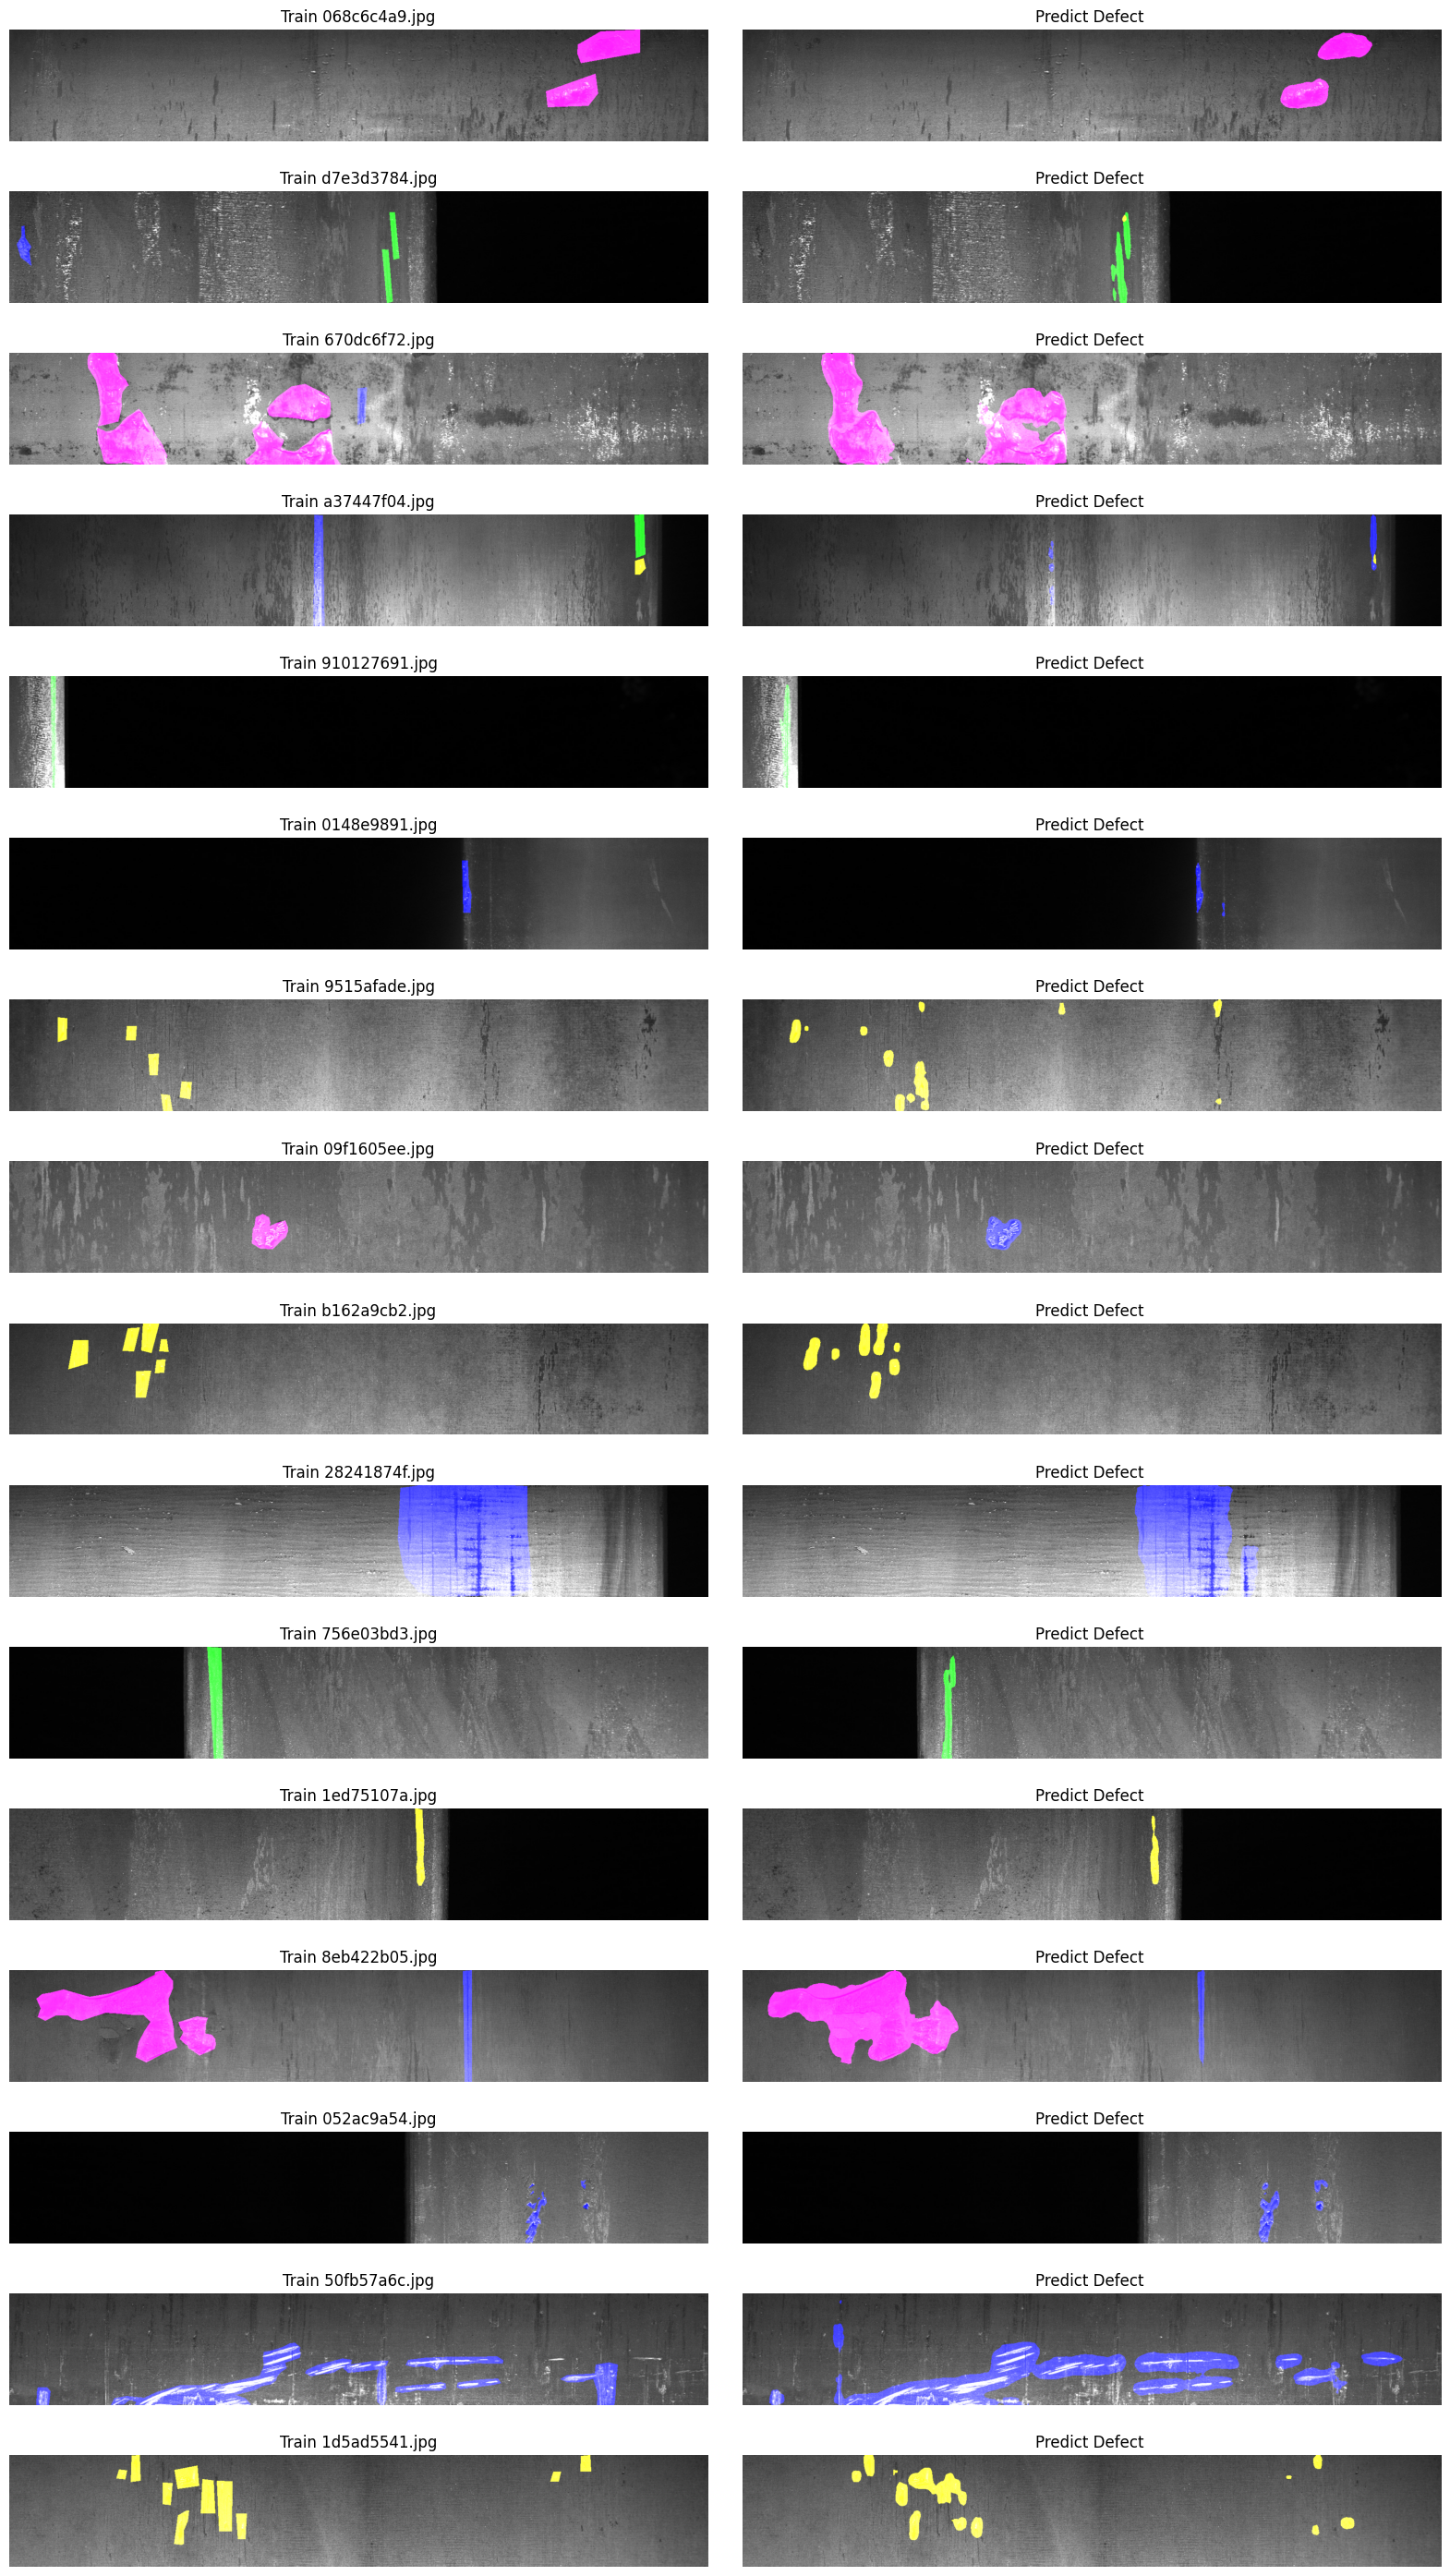

In [ ]:
from skimage.morphology import remove_small_objects

defects = list(valid_df[valid_df['e1']!=''].sample(4).index)
defects += list(valid_df[valid_df['e2']!=''].sample(4).index)
defects += list(valid_df[valid_df['e3']!=''].sample(4).index)
defects += list(valid_df[valid_df['e4']!=''].sample(4).index)

valid_batches_pred = DataGenerator2(valid_df[valid_df.index.isin(defects)], subset="train", batch_size=8, plot_mode=True, label_sparse=False, mask_label_mode='multi')

preds = DeeplabV3.predict(valid_batches_pred,verbose=1)

threshold = [0.5,0.5,0.5,0.5,0.5]

valid_batches = DataGenerator2(valid_df[valid_df.index.isin(defects)], batch_size=16, plot_mode=True, label_sparse=False, mask_label_mode='multi')
print('Plotting predictions...')
print('KEY: yellow=defect1, green=defect2, blue=defect3, magenta=defect4')
min_pixel = 250
for i,batch in enumerate(valid_batches):
    plt.figure(figsize=(20,36))
    for k in range(16):
        plt.subplot(16,2,2*k+1)
        img = batch[0][k,]
        img_1 = img.copy()
        img_2 = img.copy()
        # img_1 = np.array(img_1, np.int32)
        # img_2 = np.array(img_2, np.int32)  
        extra = '  has defect '
        
        # msk = batch[1][k,:,:,0]
        msk = batch[1][k,]
        if len(np.unique(msk))>1: 
          for n in range(4):
            if n ==0:
              # yellow
              img_1[msk[:,:,n+1]==1,0] = 235 
              img_1[msk[:,:,n+1]==1,1] = 235
            if n ==1:
              # green
              img_1[msk[:,:,n+1]==1,1] = 210 
            if n ==2:
              # blue
              img_1[msk[:,:,n+1]==1,2] = 255
            if n ==3:
              # magenta          
              img_1[msk[:,:,n+1]==1,0] = 255
              img_1[msk[:,:,n+1]==1,2] = 255

        if extra=='  has defect ': extra =''
        plt.title('Train '+train_df2_shuffle.iloc[16*i+k,0])
        plt.axis('off') 
        plt.imshow(img_1)
        
############################# Plot Predict reslut #############################################
        plt.subplot(16,2,2*k+2)
        extra_pred = ' has defect'
        
        thresholded = np.argmax(preds[16*i+k,], axis=2)                        

        # yellow
        img_2[thresholded==1,0] = 255 
        img_2[thresholded==1,1] = 255
        # green
        img_2[thresholded==2,1] = 210
        # blue
        img_2[thresholded==3,2] = 255 
        # magenta
        img_2[thresholded==4,0] = 255
        img_2[thresholded==4,2] = 255 
       
        plt.axis('off')      
        plt.title('Predict Defect ')
        plt.subplots_adjust(wspace=0.05)       
        plt.imshow(img_2)

    plt.subplots_adjust(wspace=0.05)
    plt.show()

In [ ]:
blockLength = 100
f1_score = F1_score(threshold=None, average=False, task='segment')

for begin in np.arange(0,len(valid_df),blockLength):
  test_batch = DataGenerator2(valid_df[begin:begin+blockLength], batch_size=1, plot_mode=True, label_sparse=False, mask_label_mode='multi', pixel_half=False)
  predict_result = DeeplabV3.predict(test_batch, verbose=1)
  for idx, true_batch in enumerate(test_batch):
    pred = predict_result[idx]
    pred = pred[np.newaxis,]
    true_batch_squ = np.squeeze(true_batch[1], axis=0)
    f1_score.update_state(y_true=true_batch[1], y_pred=pred)

print('F1score Defect 1: ',f1_score.result().numpy()[1])
print('F1score Defect 2: ',f1_score.result().numpy()[2])
print('F1score Defect 3: ',f1_score.result().numpy()[3])
print('F1score Defect 4: ',f1_score.result().numpy()[4])

67/67 [==============================] - 3s 48ms/step
F1score Defect 1:  0.6150031
F1score Defect 2:  0.6506577
F1score Defect 3:  0.77022123
F1score Defect 4:  0.78079736


## 7.3.Unet

In [ ]:
# github: https://github.com/qubvel/segmentation_models.git
! pip install segmentation-models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 6.8 MB/s eta 0:00:00


In [ ]:
%env SM_FRAMEWORK=tf.keras
from segmentation_models import Unet
from segmentation_models import FPN

# dicecceLoss = DiceCCELoss(CCE_weights=0.7, Dice_weights=0.3)

# # printing the value of the learning rate
# def get_lr_metric(optimizer):  
#     def lr(y_true, y_pred):
#         return optimizer.lr
#     return lr

adam = tf.keras.optimizers.Adam(learning_rate=8e-5)
adamW = tf.keras.optimizers.experimental.AdamW(learning_rate=1e-03, weight_decay=0.000001)
sgd = tf.keras.optimizers.SGD(learning_rate=1e-05, momentum=0.9, weight_decay=0.00001)

tcl = TverskyCCELoss(CCE_weights=0.6, tversky_weights=0.4, alpha=0.7) # Tversky = (TP + smooth) / (TP + (1-alpha)*FP + (alpha)*FN + smooth) 
ftcl = FocalTversky_CCELoss(CCE_weights=0.5, focal_tversky_weights=0.5, alpha=0.3, gamma=1.5, class_weights=[1.0, 2.0, 2.0, 1.0, 1.5])
wcce = weighted_categoricalCE_loss(class_weights=[1.0, 2.0, 2.0, 1.0, 1.5])

with one_strategy.scope():
  BACKBONE = 'efficientnetb4'
  model_seg = Unet(BACKBONE, input_shape=(None, None, 3), classes=5, activation='softmax', encoder_weights='imagenet')
  model_seg.compile(optimizer=sgd,                 
                loss = ftcl, 
                metrics=[F1_score(threshold=None, average=True, ignore_ground=True, task='segment', num_classes=5)])
  



env: SM_FRAMEWORK=tf.keras
71892840/71892840 [==============================] - 4s 0us/step


In [ ]:
model_seg.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 stem_conv (Conv2D)             (None, None, None,   1296        ['input_4[0][0]']                
                                48)                                                               
                                                                                                  
 stem_bn (BatchNormalization)   (None, None, None,   192         ['stem_conv[0][0]']              
                                48)                                                         

In [ ]:
# Loading weights
model_seg.load_weights('/content/gdrive/MyDrive/project/kaggle/Severstal_Steel Defect Detection_/Unet_b5_ftcl_3.hdf5')

### 7.2.1.Training

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger

# reduce_lr_custom = ReduceLROnPlateau_custom(monitor='val_loss', mode="min", factor=0.1, patience=3, cooldown=5, min_lr=1e-8, eps=1e-09, verbose=True)

checkpoint_filepath = '/content/gdrive/MyDrive/project/kaggle/Severstal_Steel Defect Detection_/Unet_b5_ftcl_4.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_F1_score',
    mode='max',
    save_best_only=True)

# lrate = LearningRateScheduler(scheduler)  
log_csv = CSVLogger('/content/gdrive/MyDrive/project/kaggle/Severstal_Steel Defect Detection_/FPN_EfficientNet_cce-dice_cw_aug4_crop256-416_radam-b4_GA/log_Unet_b5_ftcl_4.csv', separator=',', append=False)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience= 10 , mode = 'min')


In [ ]:
train_batches = DataGenerator2(train_df[:], subset='train', input_size=(256,1600), batch_size=3, plot_mode=True, pixel_half=False, shuffle=True, augment_transform=augmentations, label_sparse=False, mask_label_mode='multi')
valid_batches = DataGenerator2(valid_df[:], subset='val', input_size=(256,1600), batch_size=3, plot_mode=True, pixel_half=False, label_sparse=False, mask_label_mode='multi')

epochs = 20
total_steps = len(train_batches)* epochs
# 5% of the steps
warmup_steps = int(0.05*total_steps)
lr_callback = WarmupCosineDecay(total_steps=total_steps, 
                             warmup_steps=warmup_steps,
                             hold=0, 
                             start_lr=1e-15, 
                             target_lr=1e-05,
                             warmup=False)

callback_list = [log_csv, model_checkpoint_callback, es, lr_callback]

history = model_seg.fit(train_batches, validation_data = valid_batches, epochs=epochs ,verbose=1, callbacks=callback_list)

Epoch 1/20
 936/2999 [========>.....................] - ETA: 33:44 - loss: 0.5456 - F1_score: 0.4280

KeyboardInterrupt: ignored

In [ ]:
log = pd.read_csv('/content/gdrive/MyDrive/專案/kaggle/Severstal_Steel Defect Detection_/Unet_cce_dice_loss_aug4/logger.csv')

plt.figure(figsize=(15,5))
plt.plot(range(history.epoch[-1]+1),history.history['val_F1_score'],label='val_F1_score')
plt.plot(range(history.epoch[-1]+1),history.history['F1_score'],label='trn_F1_score')
plt.title('Training F1_score'); plt.xlabel('Epoch'); plt.ylabel('F1_score');plt.legend(); 
plt.show()

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(range(history.epoch[-1]+1),history.history['val_loss'],label='val_loss')
plt.plot(range(history.epoch[-1]+1),history.history['loss'],label='trn_loss')
plt.title('Learning curve'); plt.xlabel('Epoch'); plt.ylabel('loss');plt.legend(); 
plt.show()

### 7.2.2.Evaluating

2/2 [==============================] - 30s 35ms/step
Plotting predictions...
KEY: yellow=defect1, green=defect2, blue=defect3, magenta=defect4


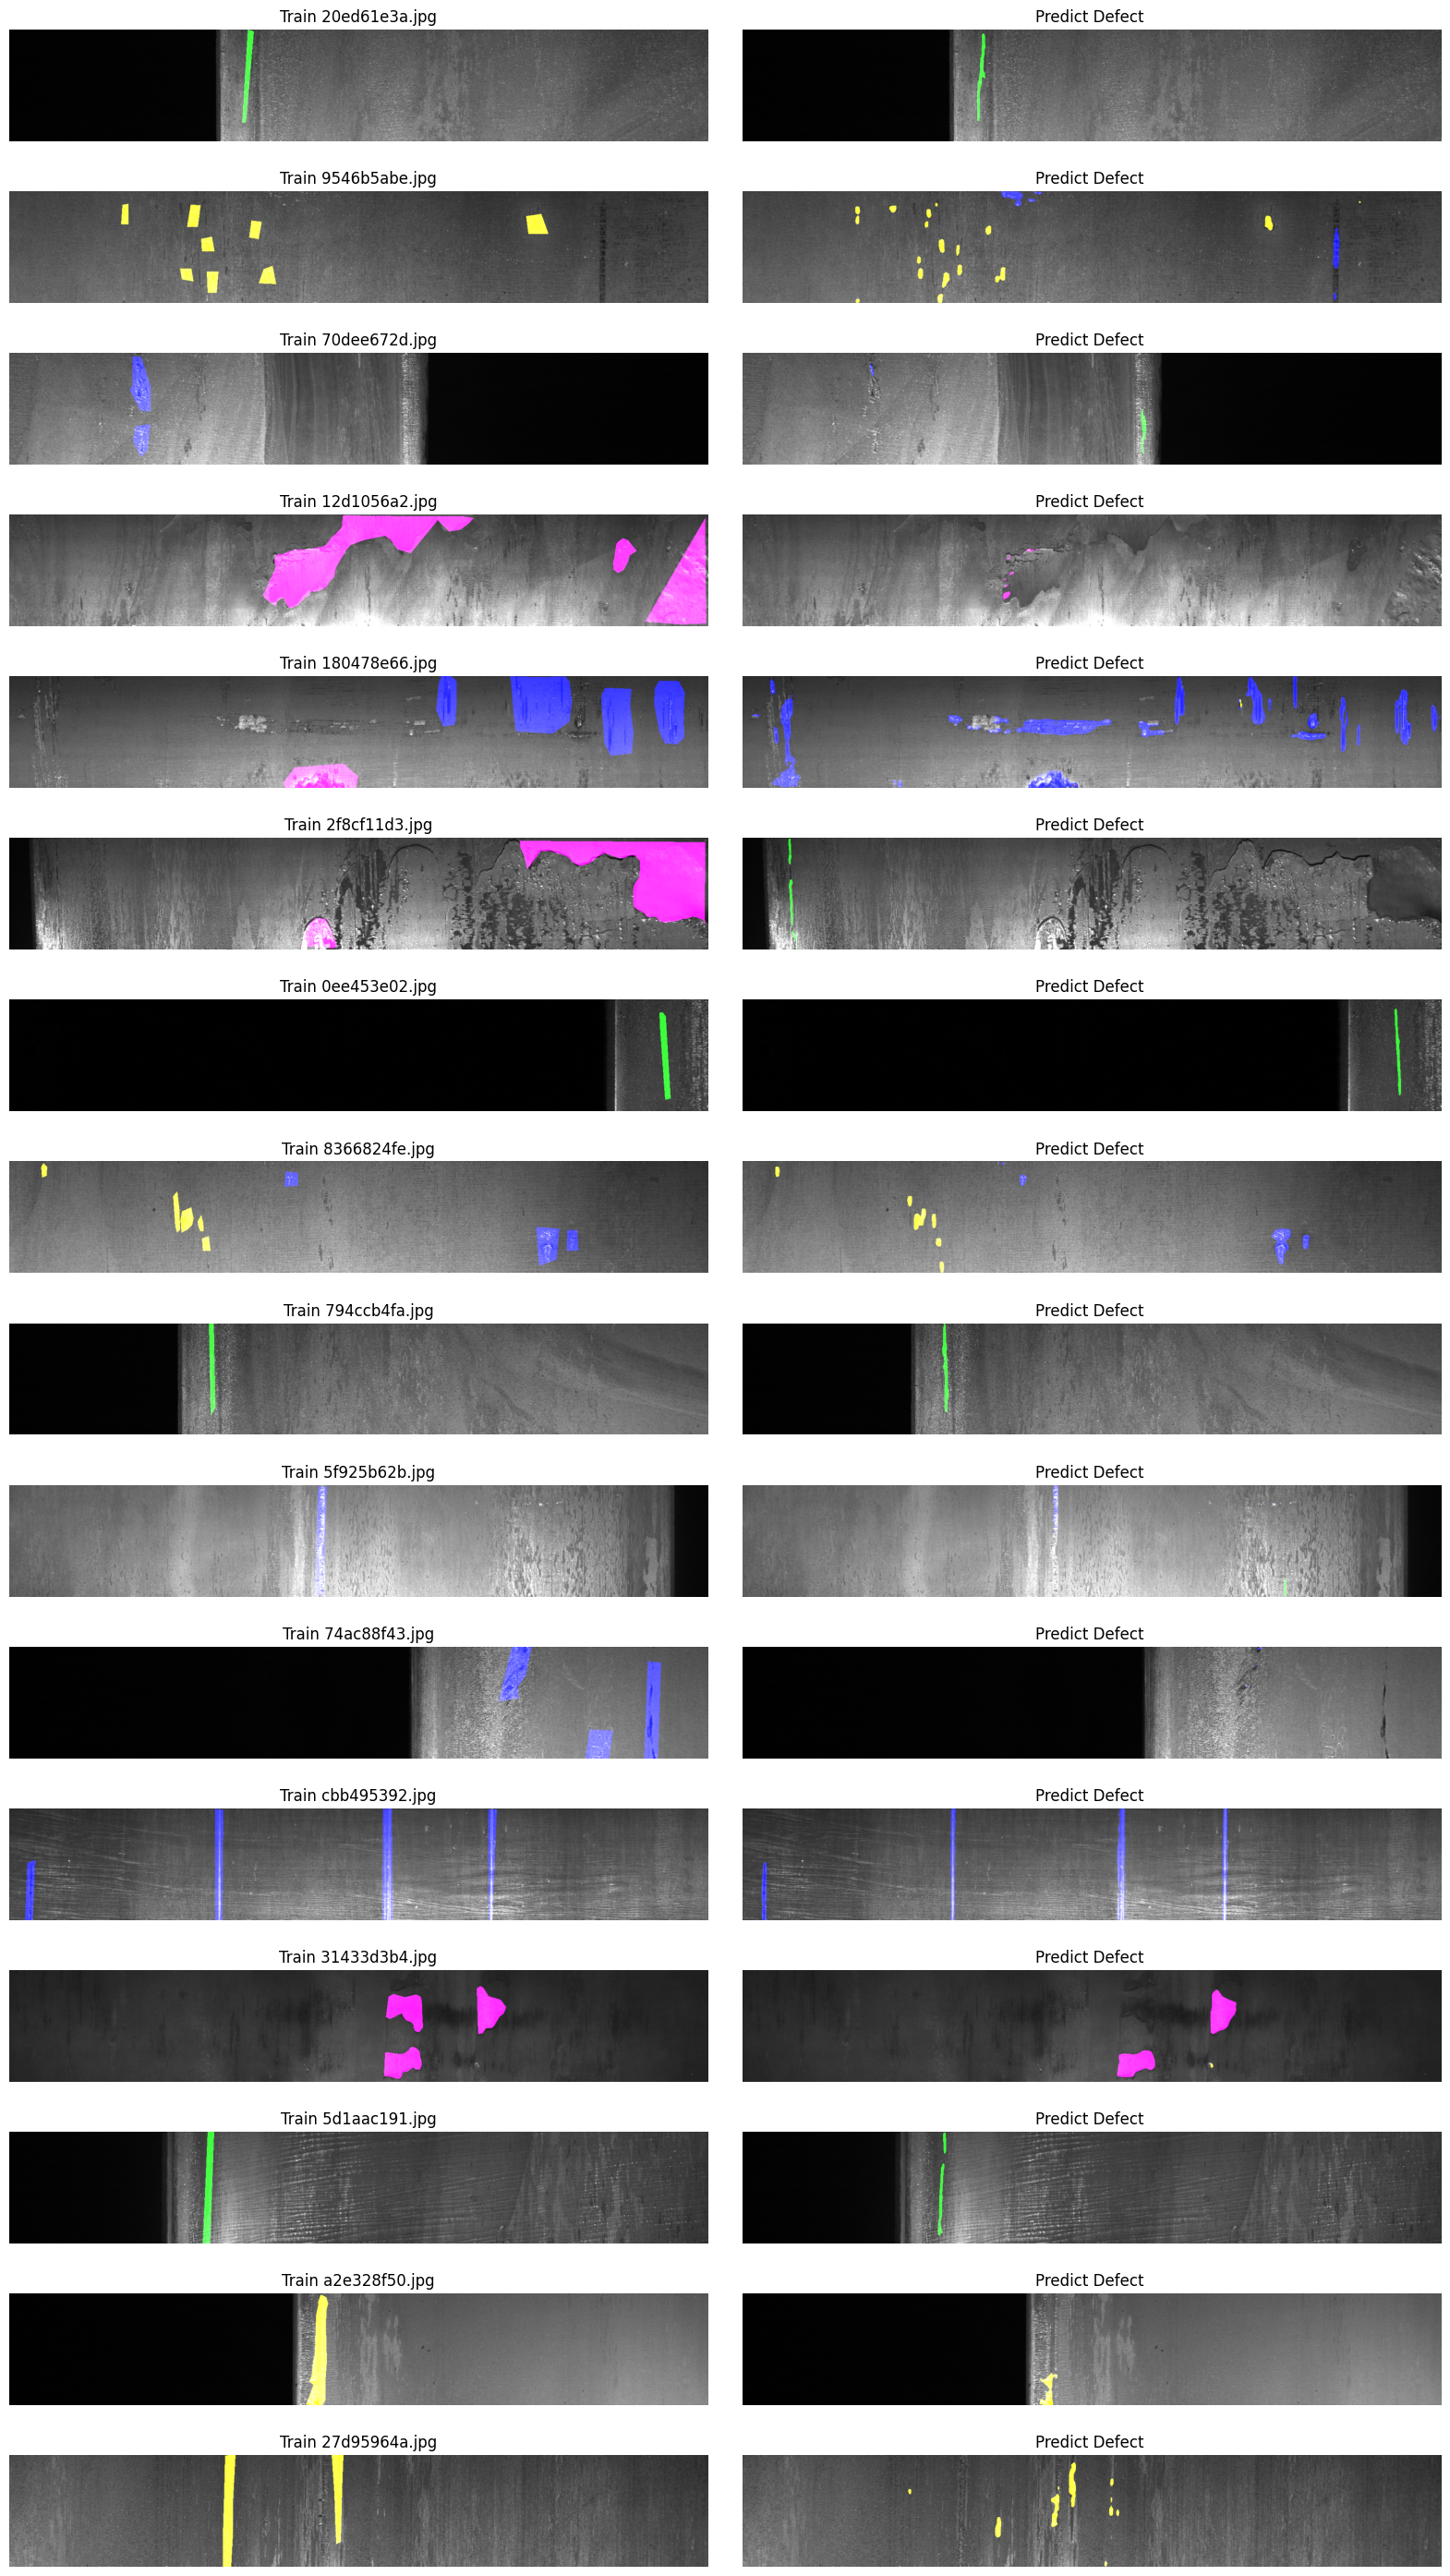

In [ ]:
from skimage.morphology import remove_small_objects

defects = list(valid_df[valid_df['e1']!=''].sample(4).index)
defects += list(valid_df[valid_df['e2']!=''].sample(4).index)
defects += list(valid_df[valid_df['e3']!=''].sample(4).index)
defects += list(valid_df[valid_df['e4']!=''].sample(4).index)

valid_batches_pred = DataGenerator2(valid_df[valid_df.index.isin(defects)], subset="train", batch_size=8, plot_mode=True, label_sparse=False, mask_label_mode='multi')

preds = model_seg.predict(valid_batches_pred,verbose=1)

threshold = [0.5,0.5,0.5,0.5,0.5]

valid_batches = DataGenerator2(valid_df[valid_df.index.isin(defects)], batch_size=16, plot_mode=True, label_sparse=False, mask_label_mode='multi')
print('Plotting predictions...')
print('KEY: yellow=defect1, green=defect2, blue=defect3, magenta=defect4')
min_pixel = 250
for i,batch in enumerate(valid_batches):
    plt.figure(figsize=(20,36))
    for k in range(16):
        plt.subplot(16,2,2*k+1)
        img = batch[0][k,]
        img_1 = img.copy()
        img_2 = img.copy()
        # img_1 = np.array(img_1, np.int32)
        # img_2 = np.array(img_2, np.int32)  
        extra = '  has defect '
        
        # msk = batch[1][k,:,:,0]
        msk = batch[1][k,]
        if len(np.unique(msk))>1: 
          for n in range(4):
            if n ==0:
              # yellow
              img_1[msk[:,:,n+1]==1,0] = 235 
              img_1[msk[:,:,n+1]==1,1] = 235
            if n ==1:
              # green
              img_1[msk[:,:,n+1]==1,1] = 210 
            if n ==2:
              # blue
              img_1[msk[:,:,n+1]==1,2] = 255
            if n ==3:
              # magenta          
              img_1[msk[:,:,n+1]==1,0] = 255
              img_1[msk[:,:,n+1]==1,2] = 255

        if extra=='  has defect ': extra =''
        plt.title('Train '+train_df2_shuffle.iloc[16*i+k,0])
        plt.axis('off') 
        plt.imshow(img_1)
        
############################# Plot Predict reslut #############################################
        plt.subplot(16,2,2*k+2)
        extra_pred = ' has defect'
        
        thresholded = np.argmax(preds[16*i+k,], axis=2)                        

        # yellow
        img_2[thresholded==1,0] = 255 
        img_2[thresholded==1,1] = 255
        # green
        img_2[thresholded==2,1] = 210
        # blue
        img_2[thresholded==3,2] = 255 
        # magenta
        img_2[thresholded==4,0] = 255
        img_2[thresholded==4,2] = 255 
       
        plt.axis('off')      
        plt.title('Predict Defect ')
        plt.subplots_adjust(wspace=0.05)       
        plt.imshow(img_2)

    plt.subplots_adjust(wspace=0.05)
    plt.show()

In [ ]:
blockLength = 100
f1_score = F1_score(threshold=None, average=False, task='segment')

for begin in np.arange(0,len(valid_df),blockLength):
  test_batch = DataGenerator2(valid_df[begin:begin+blockLength], batch_size=1, plot_mode=True, label_sparse=False, mask_label_mode='multi', pixel_half=False)
  predict_result = model_seg.predict(test_batch, verbose=1)
  for idx, true_batch in enumerate(test_batch):
    pred = predict_result[idx]
    pred = pred[np.newaxis,]
    true_batch_squ = np.squeeze(true_batch[1], axis=0)
    f1_score.update_state(y_true=true_batch[1], y_pred=pred)

print('F1score Defect 1: ',f1_score.result().numpy()[1])
print('F1score Defect 2: ',f1_score.result().numpy()[2])
print('F1score Defect 3: ',f1_score.result().numpy()[3])
print('F1score Defect 4: ',f1_score.result().numpy()[4])